<a href="https://colab.research.google.com/github/BogdanT54/Financial-Markets-Analysis/blob/main/Solana_Palantir_Gold_Financial_Anaisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Solana, Gold & Palantir – Financial Risk Analysis

## 🔍 Project Overview
This project analyzes the risk profiles of three financial assets — **Solana (cryptocurrency)**, **Gold (commodity)**, and **Palantir (stock)** — both individually and as part of a portfolio. The study follows the requirements of the *Statistics of Financial Markets* course, covering return distributions, volatility modeling, and portfolio risk estimation.

---

## 📂 Data Sources
- **Solana (SOL-USD)** – Yahoo Finance (daily OHLC data)  
- **Gold (XAU-USD)** – Yahoo Finance (daily OHLC data)  
- **Palantir (PLTR)** – Yahoo Finance (daily OHLC data)  

Data was collected and cleaned in Python using `yfinance` and `pandas`.

---

## 📊 Methodology & Econometric Models

### 1. Distribution Properties of Returns
- Computed log returns for each asset.
- Analyzed **mean, variance, skewness, and kurtosis**.
- Conducted **normality tests** (Jarque-Bera, Shapiro-Wilk) to assess deviations from Gaussian behavior.

### 2. Extreme Returns Analysis
- Estimated **Value at Risk (VaR)** using historical simulation.
- Calculated the **probabilities of extreme losses** beyond chosen quantiles.

### 3. Efficient Market Hypothesis (Weak Form)
- Applied **Augmented Dickey-Fuller (ADF)** and **Runs tests** to check for randomness and weak-form efficiency.

### 4. Fractal Market Hypothesis
- Estimated the **Hurst exponent** to assess the presence of long-term memory or fractal structure in price movements.

### 5. Volatility Modeling – GARCH Family
- Modeled conditional variance using **GARCH(1,1)** and **EGARCH** to capture volatility clustering.
- Compared fitted volatility with observed market movements.

### 6. Portfolio Risk Profile
- Built a portfolio of the three assets:
  - **Equal weights** (baseline portfolio)
  - **Alternative weightings** (optimized for minimum variance)
- Computed portfolio **VaR** and **volatility** on **rolling windows**.

---

## 📈 Conclusions & Insights
- Each asset displayed **non-normal returns**, with fat tails and volatility clustering.
- **GARCH models** successfully captured time-varying volatility patterns.
- Portfolio diversification reduced total risk, but **cryptocurrency exposure (Solana)** significantly increased tail risk.
- **Weak form efficiency** tests suggested partial predictability in returns, more evident for Gold and Palantir than Solana.
- Fractal market analysis indicated some persistence, especially in commodity prices.

In [ ]:
!pip install numpy pandas matplotlib seaborn yfinance statsmodels scipy arch nolds requests pingouin powerlaw hurst MFDFA nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.0 MB/s eta 0:00:00


In [ ]:
# 📦 Visualization and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Data
import yfinance as yf

# 📊 Statistics
from scipy import stats
from scipy.stats import skew, kurtosis, pareto, norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera

# 📉 GARCH Modelling
from arch import arch_model
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from arch.unitroot import VarianceRatio

# 💰 Value at Risk
from statsmodels.distributions.empirical_distribution import ECDF

# 🔁 Rolling window + regresion
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# 📐 Hurst Exponent
import nolds

import powerlaw as powerlaw

# **Descarcare si prelucrare date**

In [ ]:
solana = yf.download('SOL-USD', period='5y', interval='1d')
palantir = yf.download('PLTR', period='5y', interval='1d')
gold = yf.download('GC=F', period='5y', interval='1d')
vix = yf.download('^VIX', start='2005-01-01', end='2025-12-30', interval='1d')

solana.to_csv('solana.csv')
palantir.to_csv('palantir.csv')
gold.to_csv('gold.csv')
vix.to_csv('VIX_05_25_DAILY.csv')

solana = solana.dropna()
palantir = palantir.dropna()
gold = gold.dropna()

gold.head(-1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open Volume
Ticker             GC=F         GC=F         GC=F         GC=F   GC=F
Date                                                                 
2020-06-08  1698.300049  1699.400024  1675.900024  1679.099976    587
2020-06-09  1714.699951  1720.900024  1692.000000  1694.599976    690
2020-06-10  1713.300049  1740.800049  1711.900024  1716.099976    718
2020-06-11  1732.000000  1744.099976  1720.000000  1737.199951    347
2020-06-12  1729.300049  1743.000000  1724.900024  1724.900024    318
...                 ...          ...          ...          ...    ...
2025-05-30  3288.899902  3318.000000  3270.899902  3315.100098   2213
2025-06-02  3370.600098  3380.800049  3296.899902  3296.899902    976
2025-06-03  3350.199951  3390.000000  3331.300049  3385.100098   6410
2025-06-04  3373.500000  3380.000000  3344.000000  3355.000000    207
2025-06-05  3350.699951  3400.000000  3343.699951  3371.500000    731

[1257 rows x 5 columns]

# **Log Returns**

In [ ]:
# Log returns + Interpolation (linear)

solana_log = np.log(solana / solana.shift(1)).dropna()
palantir_log = np.log(palantir / palantir.shift(1)).dropna()
gold_log = np.log(gold / gold.shift(1)).dropna()

merged_df = solana_log['Close'].join(palantir_log['Close'], how='outer').join(gold_log['Close'], how='outer')

palantir_log.head(-1)

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Price          Close      High       Low      Open    Volume
Ticker          PLTR      PLTR      PLTR      PLTR      PLTR
Date                                                        
2020-10-01 -0.004219 -0.121955  0.013086 -0.031491 -1.002095
2020-10-02 -0.027869 -0.084674 -0.031923 -0.067225 -0.815013
2020-10-05 -0.018651  0.022377 -0.002240  0.040027 -0.415383
2020-10-06  0.091982  0.070186 -0.002245 -0.042237  0.917081
2020-10-07  0.010050  0.029997  0.115533  0.104918 -0.508005
...              ...       ...       ...       ...       ...
2025-05-28  0.002994 -0.017592  0.016654 -0.020634 -0.287303
2025-05-29 -0.011704  0.006505 -0.011291  0.008975 -0.027002
2025-05-30  0.074493  0.042342  0.009989 -0.014626  1.079875
2025-06-02  0.001971  0.019068  0.048577  0.062028 -0.690248
2025-06-03  0.008522  0.005931  0.009577  0.012363 -0.023827

[1173 rows x 5 columns]

# **GRAFICE LOG-RETURN**

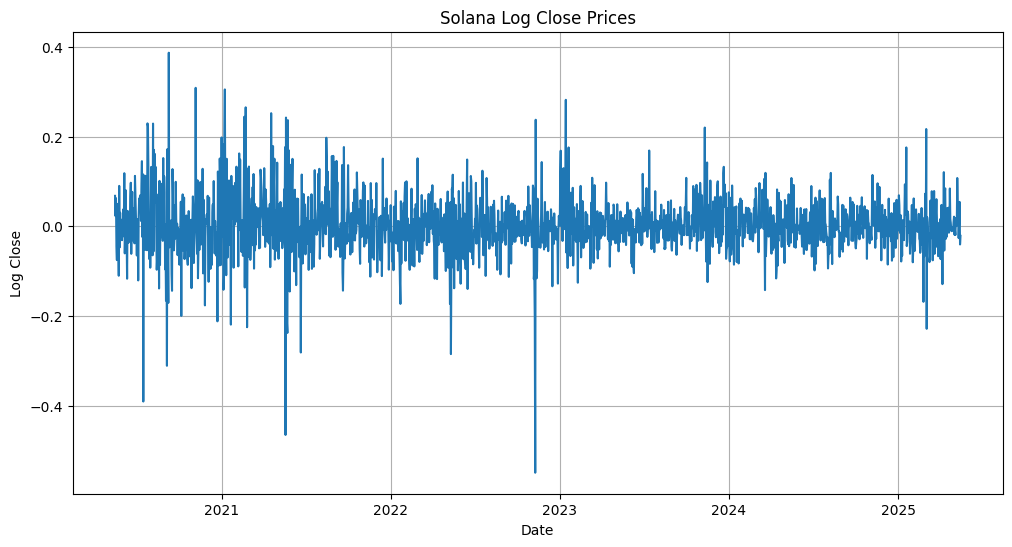

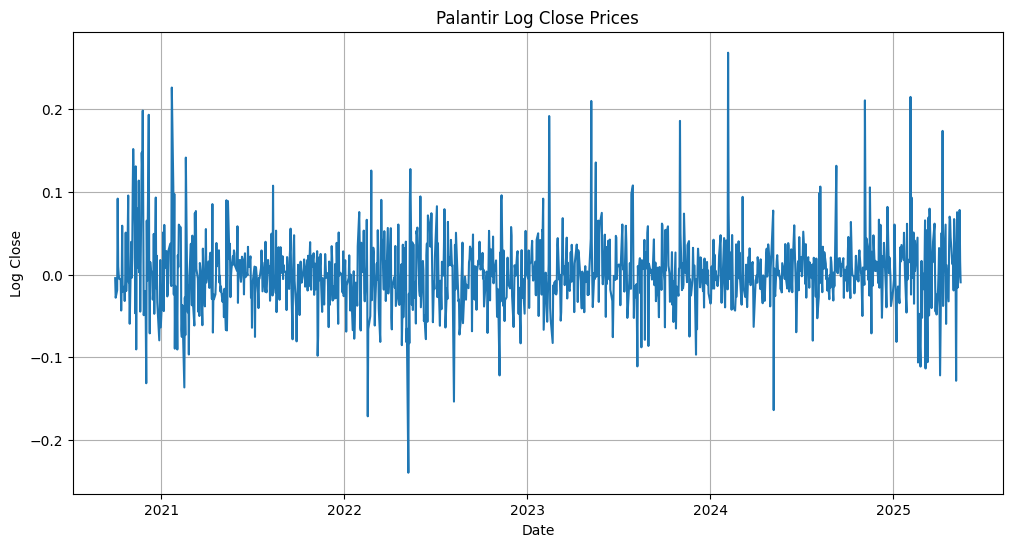

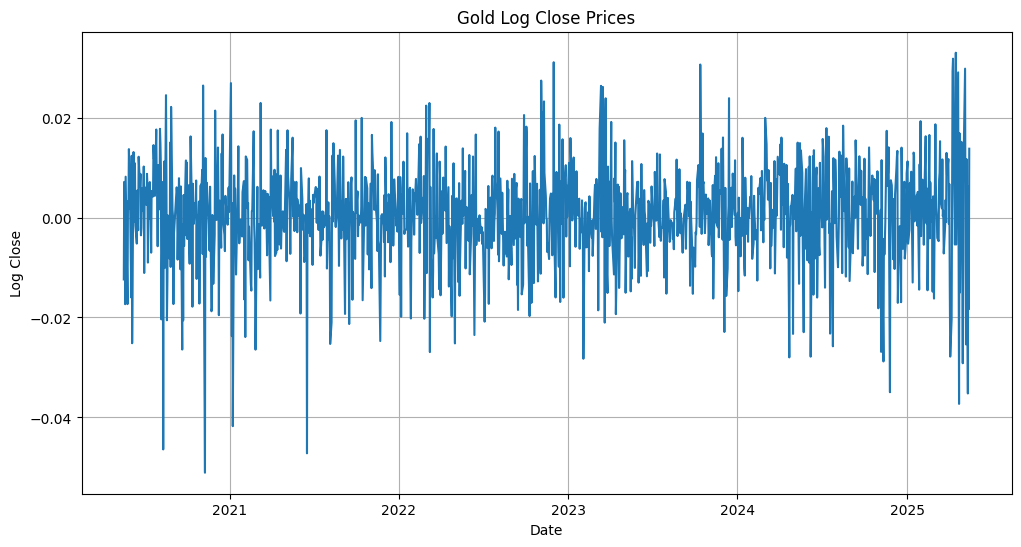

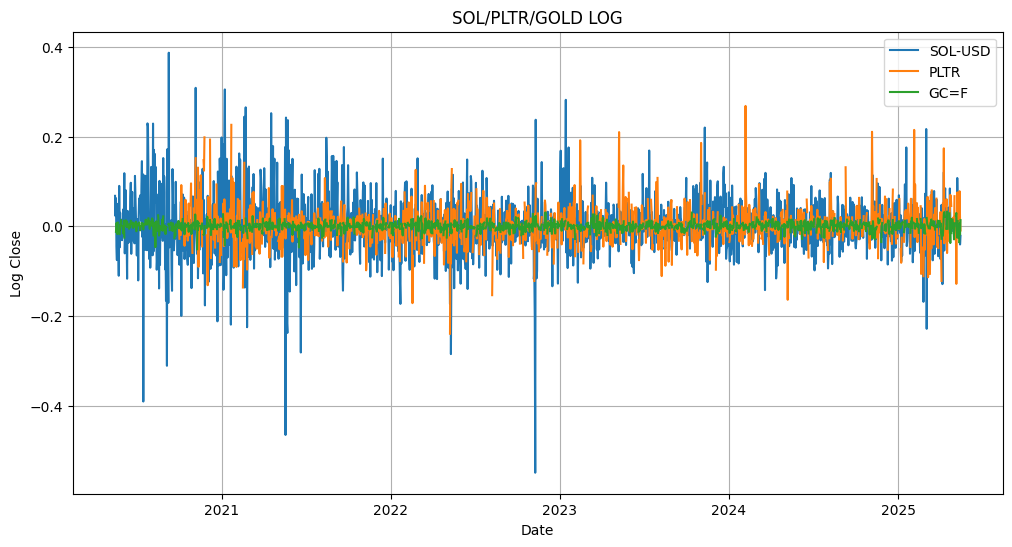

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(solana_log['Close'])
plt.title('Solana Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Log Close')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(palantir_log['Close'])
plt.title('Palantir Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Log Close')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(gold_log['Close'])
plt.title('Gold Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Log Close')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_df)
plt.title('SOL/PLTR/GOLD LOG')
plt.xlabel('Date')
plt.ylabel('Log Close')
plt.legend(merged_df.columns, loc='upper right')
plt.grid(True)
plt.show()

# **STATISTICI STANDARD/MOMENTE**

In [ ]:
def calculeaza_momente(serie):
    serie = serie.dropna()

    mean_val = serie.mean().item()
    std_val = serie.std().item()
    var_val = serie.var().item()
    skew_val = skew(serie, bias=False).item()
    kurt_val = (kurtosis(serie, bias=False)).item()  # kurt standard
    cv_val = (std_val / abs(mean_val))

    return {
        'N': len(serie),
        'Mean': mean_val,
        'Std Deviation': std_val,
        'Variance': var_val,
        'Skewness': skew_val,
        'Kurtosis': kurt_val,
        'Coeff Variation': cv_val
    }


sol = calculeaza_momente(solana_log['Close'])
pltr = calculeaza_momente(palantir_log['Close'])
gold = calculeaza_momente(gold_log['Close'])

momente_df = pd.DataFrame([sol, pltr, gold], index=['Solana', 'Palantir', 'Gold']).round(6)
momente_df

N      Mean  Std Deviation  Variance  Skewness  Kurtosis  \
Solana    1826  0.003143       0.065989  0.004355 -0.249868  7.218949   
Palantir  1160  0.002253       0.045286  0.002051  0.650615  4.587048   
Gold      1257  0.000482       0.009931  0.000099 -0.539721  2.205496   

          Coeff Variation  
Solana          20.997216  
Palantir        20.098808  
Gold            20.610101

# **EXTREME VALUES**

In [ ]:
def afiseaza_extreme(df_log_returns, n):
    """
    Displays the n smallest and n largest observations from the 'Close' column
    of a DataFrame containing log returns.

    Parameters:
    - df_log_returns: DataFrame (e.g., solana_log)
    - n: number of extreme observations to display
    """
    import pandas as pd

    # Extract the 'Close' returns series
    series = df_log_returns['Close']
    if isinstance(series, pd.DataFrame):
        series = series.squeeze()
    series = series.dropna()

    # Smallest and largest values
    lowest = series.nsmallest(n)
    highest = series.nlargest(n)

    # Build DataFrames
    lowest_df = pd.DataFrame({
        'Value': lowest.values,
        'Date': lowest.index.date,
        'Obs': [series.index.get_loc(x) for x in lowest.index]
    })

    highest_df = pd.DataFrame({
        'Value': highest.values,
        'Date': highest.index.date,
        'Obs': [series.index.get_loc(x) for x in highest.index]
    })

    # Combine
    extremes_df = pd.concat([lowest_df.reset_index(drop=True),
                             highest_df.reset_index(drop=True)], axis=1)

    extremes_df.columns = ['Lowest Value', 'Lowest Date', 'Lowest Obs',
                           'Highest Value', 'Highest Date', 'Highest Obs']

    # Display
    from IPython.display import display
    display(extremes_df)


# Extreme Solana
print("\nExtreme Solana")
afiseaza_extreme(solana_log, 10)

# Extreme Palantir
print("\nExtreme Palantir")
afiseaza_extreme(palantir_log, 10)

# Extreme Gold
print("\nExtreme Gold")
afiseaza_extreme(gold_log, 10)



 Extreme Solana


Lowest Value Lowest Date  Lowest Obs  Highest Value Highest Date  \
0     -0.549582  2022-11-09         918       0.387184   2020-09-09   
1     -0.465355  2021-05-19         379       0.308867   2020-11-06   
2     -0.390791  2020-07-16          72       0.305299   2021-01-08   
3     -0.311053  2020-09-05         123       0.282125   2023-01-14   
4     -0.284965  2022-05-11         736       0.265386   2021-02-22   
5     -0.281440  2021-06-21         412       0.252295   2021-04-18   
6     -0.237768  2021-05-23         383       0.244306   2021-02-19   
7     -0.228588  2025-03-03        1763       0.242524   2021-05-20   
8     -0.225035  2021-02-25         296       0.237690   2022-11-10   
9     -0.219232  2021-01-21         261       0.236746   2021-05-24   

   Highest Obs  
0          127  
1          185  
2          248  
3          984  
4          293  
5          348  
6          290  
7          380  
8          919  
9          384


 Extreme Palantir


Lowest Value Lowest Date  Lowest Obs  Highest Value Highest Date  \
0     -0.239629  2022-05-09         403       0.268510   2024-02-06   
1     -0.171358  2022-02-17         348       0.226372   2021-01-22   
2     -0.163850  2024-05-07         904       0.215038   2025-02-04   
3     -0.153569  2022-08-08         465       0.210849   2024-11-05   
4     -0.136446  2021-02-16          93       0.210140   2023-05-09   
5     -0.131363  2020-12-02          43       0.198493   2020-11-25   
6     -0.121890  2022-11-07         529       0.193441   2020-12-07   
7     -0.121843  2025-04-04        1132       0.191912   2023-02-14   
8     -0.113493  2025-03-06        1111       0.186001   2023-11-02   
9     -0.111243  2025-02-24        1103       0.173945   2025-04-09   

   Highest Obs  
0          841  
1           77  
2         1090  
3         1030  
4          654  
5           39  
6           46  
7          596  
8          777  
9         1135


 Extreme Gold


Lowest Value Lowest Date  Lowest Obs  Highest Value Highest Date  \
0     -0.051069  2020-11-09         131       0.032973   2025-04-16   
1     -0.047183  2021-06-17         282       0.031781   2025-04-10   
2     -0.046407  2020-08-11          68       0.031070   2022-12-01   
3     -0.041753  2021-01-08         172       0.030608   2023-10-13   
4     -0.037296  2025-04-23        1243       0.029247   2025-04-09   
5     -0.034959  2024-11-25        1142       0.029042   2025-04-21   
6     -0.029166  2025-05-01        1249       0.027397   2022-11-04   
7     -0.028802  2024-11-11        1132       0.026892   2021-01-04   
8     -0.028262  2023-02-03         689       0.026409   2020-11-05   
9     -0.027990  2024-04-22         991       0.026342   2023-03-13   

   Highest Obs  
0         1239  
1         1235  
2          646  
3          861  
4         1234  
5         1241  
6          628  
7          168  
8          129  
9          714

# **Extreme Returns**

In [ ]:
# Extreme probabilities
def extreme_probabilities(returns, threshold, name='Activ'):
    prob_loss = ((returns < -threshold).mean()).item()
    prob_gain = ((returns > threshold).mean()).item()

    print(f"\n--- {name} ---")
    print(f"Probabilitate randament < -{threshold*100.0}% : {prob_loss:.3%}")
    print(f"Probabilitate randament > +{threshold*100.0}% : {prob_gain:.3%}")
    return

extreme_probabilities(solana_log['Close'], threshold=0.05, name='Solana')
extreme_probabilities(solana_log['Close'], threshold=0.10, name='Solana')
extreme_probabilities(solana_log['Close'], threshold=0.15, name='Solana')

extreme_probabilities(gold_log['Close'], threshold=0.05, name='Gold')
extreme_probabilities(gold_log['Close'], threshold=0.10, name='Gold')
extreme_probabilities(gold_log['Close'], threshold=0.15, name='Gold')

extreme_probabilities(palantir_log['Close'], threshold=0.05, name='Palantir')
extreme_probabilities(palantir_log['Close'], threshold=0.10, name='Palantir')
extreme_probabilities(palantir_log['Close'], threshold=0.15, name='Palantir')


--- Solana ---
Probabilitate randament < -5.0% : 14.513%
Probabilitate randament > +5.0% : 17.634%

--- Solana ---
Probabilitate randament < -10.0% : 3.395%
Probabilitate randament > +10.0% : 5.969%

--- Solana ---
Probabilitate randament < -15.0% : 1.095%
Probabilitate randament > +15.0% : 2.191%

--- Gold ---
Probabilitate randament < -5.0% : 0.080%
Probabilitate randament > +5.0% : 0.000%

--- Gold ---
Probabilitate randament < -10.0% : 0.000%
Probabilitate randament > +10.0% : 0.000%

--- Gold ---
Probabilitate randament < -15.0% : 0.000%
Probabilitate randament > +15.0% : 0.000%

--- Palantir ---
Probabilitate randament < -5.0% : 9.122%
Probabilitate randament > +5.0% : 10.656%

--- Palantir ---
Probabilitate randament < -10.0% : 1.194%
Probabilitate randament > +10.0% : 2.217%

--- Palantir ---
Probabilitate randament < -15.0% : 0.341%
Probabilitate randament > +15.0% : 0.938%


# **TESTE DISTRIBUTII**

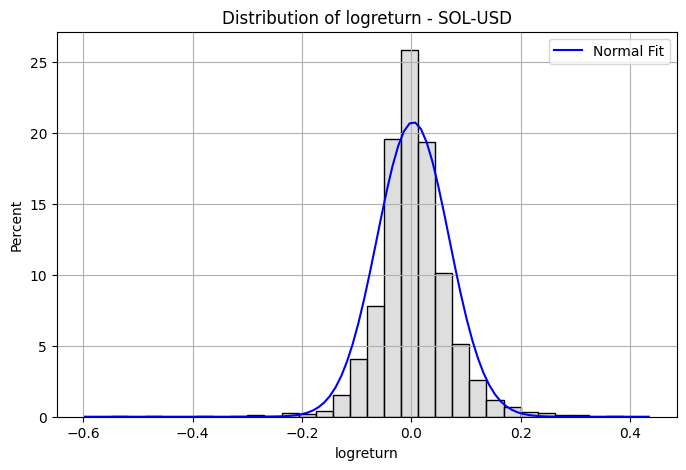

Goodness-of-Fit Tests for Normal Distribution - SOL-USD
Kolmogorov-Smirnov: D = 0.072097, p = 1.065e-08
Cramér-von Mises: W^2 = 128.698835, p ≈ 4.1e-08
Anderson-Darling: A^2 = 21.888476, Critical Values = [0.575 0.655 0.785 0.916 1.09 ]



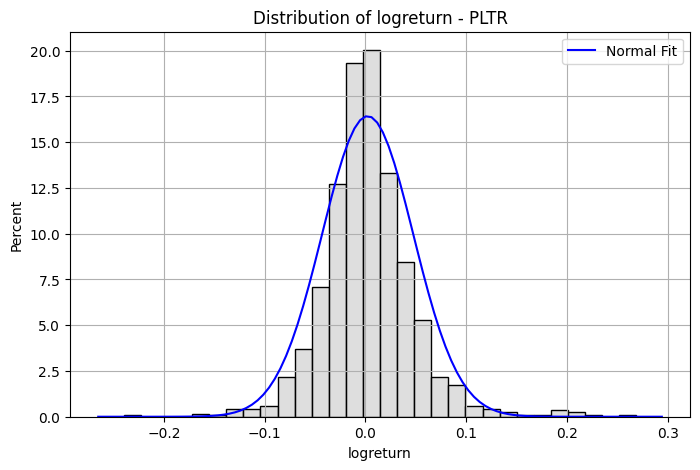

Goodness-of-Fit Tests for Normal Distribution - PLTR
Kolmogorov-Smirnov: D = 0.074665, p = 4.635e-06
Cramér-von Mises: W^2 = 85.984198, p ≈ 2.99e-08
Anderson-Darling: A^2 = 12.476144, Critical Values = [0.574 0.654 0.784 0.915 1.088]



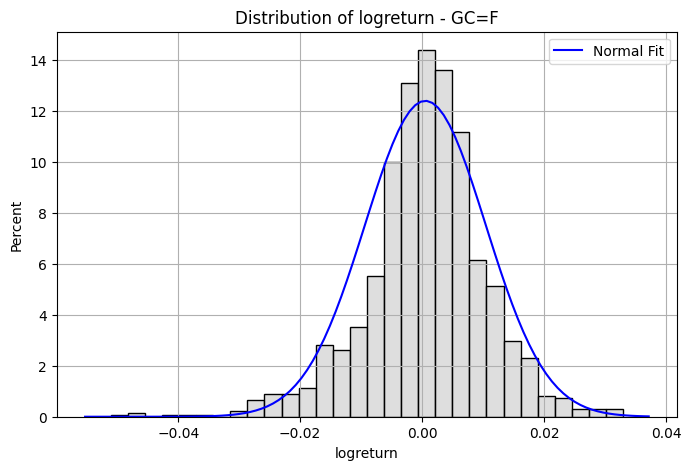

Goodness-of-Fit Tests for Normal Distribution - GC=F
Kolmogorov-Smirnov: D = 0.064356, p = 6.007e-05
Cramér-von Mises: W^2 = 101.600268, p ≈ 3.25e-08
Anderson-Darling: A^2 = 8.383930, Critical Values = [0.574 0.654 0.785 0.915 1.089]



In [ ]:
# Function for histogram + tests
def show_gof_tests(data, label):
    plt.figure(figsize=(8, 5))
    sns.histplot(data, bins=30, kde=False, stat='percent', color='lightgray')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(data), np.std(data))
    plt.plot(x, p * 100 * (xmax - xmin) / 30, 'b-', label='Normal Fit')

    plt.title(f"Distribution of logreturn - {label}")
    plt.xlabel("logreturn")
    plt.ylabel("Percent")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tests
    ks_stat, ks_p = stats.kstest((data - np.mean(data)) / np.std(data), 'norm')
    ad_result = stats.anderson(data, dist='norm')
    cvm_result = stats.cramervonmises(data, 'norm')

    print(f"Goodness-of-Fit Tests for Normal Distribution - {label}")
    print(f"Kolmogorov-Smirnov: D = {ks_stat:.6f}, p = {ks_p:.4g}")
    print(f"Cramér-von Mises: W^2 = {cvm_result.statistic:.6f}, p ≈ {cvm_result.pvalue:.3g}")
    print(f"Anderson-Darling: A^2 = {ad_result.statistic:.6f}, Critical Values = {ad_result.critical_values}\n")


for column in merged_df.columns:
    show_gof_tests(merged_df[column].dropna(), column)

# **Q-Q PLOT**

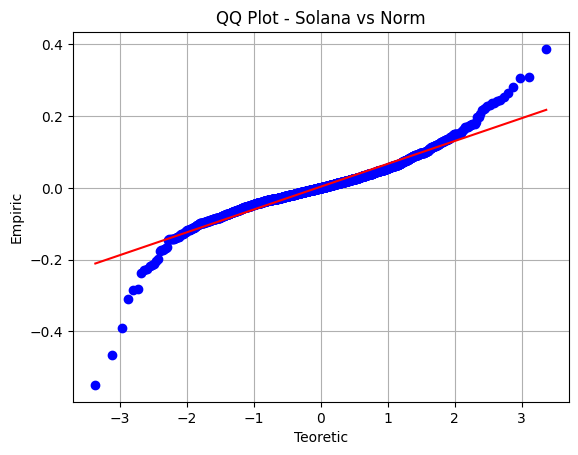

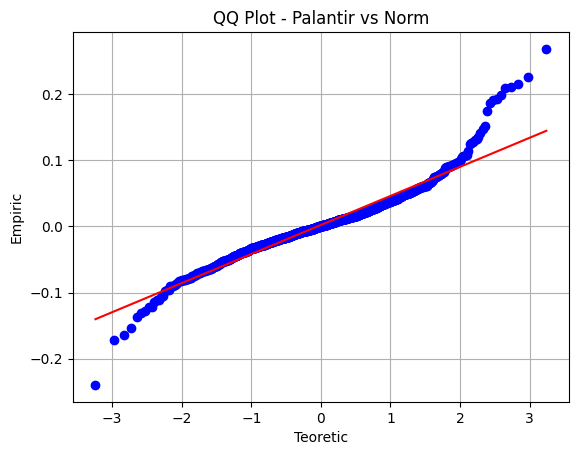

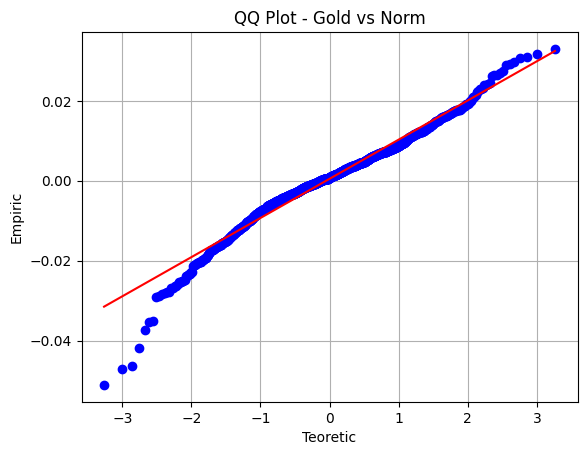

In [ ]:
def qq_plot_distribution(data, dist='norm', dist_params=(), title='QQ Plot', xlabel='Theoretical', ylabel='Empirical'):
    """
    Displays a QQ plot for a specified distribution.
    """
    # Force one-dimensional vector
    data = np.asarray(data).ravel()
    data = pd.Series(data).dropna()
    data = data[np.isfinite(data)]

    # QQ plot
    stats.probplot(data, dist=dist, sparams=dist_params, plot=plt)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

qq_plot_distribution(solana_log['Close'], dist='norm', title='QQ Plot - Solana vs Norm')
qq_plot_distribution(palantir_log['Close'], dist='norm', title='QQ Plot - Palantir vs Norm')
qq_plot_distribution(gold_log['Close'], dist='norm', title='QQ Plot - Gold vs Norm')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from arch.unitroot import VarianceRatio

def test_eficienta_pietei(log_returns, max_lag_bg=12):

    print("\n=== Ljung-Box ===")
    ljung = acorr_ljungbox(log_returns, lags=[2, 12], return_df=True)
    print(ljung)

    print("\n=== Breusch-Godfrey (AR Model) ===")
    model = AutoReg(log_returns, lags=max_lag_bg).fit()
    print(model.summary())

    print("\n=== Variance Ratio ===")
    lags_test = [2, 5, 10]
    for lag in lags_test:
        vr = VarianceRatio(log_returns, lags=lag)
        print(f"Lag {lag}: VR = {vr.vr:.4f}, p-value = {vr.pvalue:.4g}")

test_eficienta_pietei(solana_log['Close'])
test_eficienta_pietei(palantir_log['Close'])
test_eficienta_pietei(gold_log['Close'])


=== Testul Ljung-Box ===
      lb_stat  lb_pvalue
2    6.066618   0.048156
12  18.609132   0.098408

=== Testul Breusch-Godfrey (AR Model) ===


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:                SOL-USD   No. Observations:                 1826
Model:                    AutoReg(12)   Log Likelihood                2365.556
Method:               Conditional MLE   S.D. of innovations              0.066
Date:                Sat, 17 May 2025   AIC                          -4703.112
Time:                        13:25:21   BIC                          -4626.066
Sample:                    05-30-2020   HQIC                         -4674.683
                         - 05-17-2025                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0029      0.002      1.835      0.066      -0.000       0.006
SOL-USD.L1     -0.0485      0.023     -2.066      0.039      -0.095      -0.002
SOL-USD.L2      0.0298      0.024      1.267    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== Testul Ljung-Box ===
     lb_stat  lb_pvalue
2   2.898537   0.234742
12  5.427931   0.942139

=== Testul Breusch-Godfrey (AR Model) ===
                            AutoReg Model Results                             
Dep. Variable:                   GC=F   No. Observations:                 1257
Model:                    AutoReg(12)   Log Likelihood                3979.179
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Sat, 17 May 2025   AIC                          -7930.357
Time:                        13:25:21   BIC                          -7858.581
Sample:                            12   HQIC                         -7903.369
                                 1257                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.896      0.058   -1.82e-05   

# **VARIANCE RATIO / LO-MAckinlay**

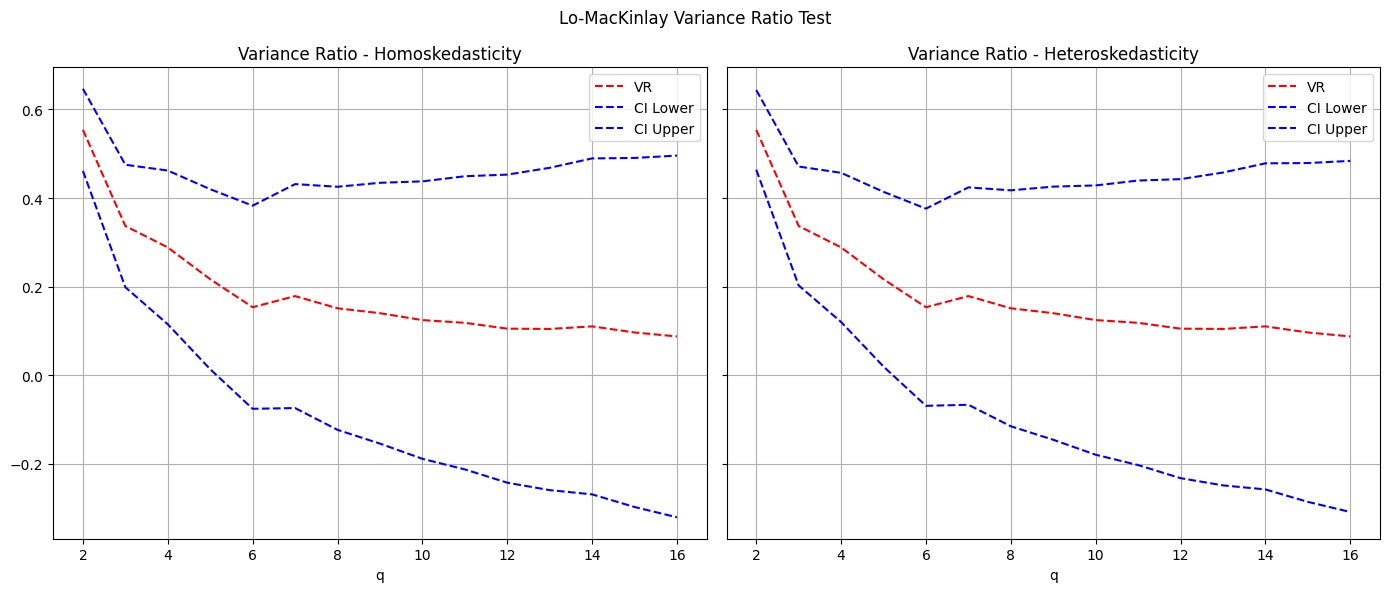

q        VR         z    z_star    z_crit  lower_homo  upper_homo  \
0    2  0.553864 -9.432375 -9.717453  1.959964    0.461161    0.646567   
1    3  0.336916 -9.404343 -9.688574  1.959964    0.198723    0.475110   
2    4  0.288582 -8.039790 -8.282779  1.959964    0.115150    0.462014   
3    5  0.216825 -7.557744 -7.786165  1.959964    0.013722    0.419927   
4    6  0.153644 -7.238467 -7.457238  1.959964   -0.075524    0.382813   
5    7  0.178774 -6.370359 -6.562893  1.959964   -0.073892    0.431440   
6    8  0.151219 -6.066600 -6.249953  1.959964   -0.123000    0.425439   
7    9  0.140161 -5.727540 -5.900646  1.959964   -0.154075    0.434398   
8   10  0.124618 -5.481493 -5.647163  1.959964   -0.188384    0.437620   
9   11  0.118448 -5.224369 -5.382267  1.959964   -0.212273    0.449169   
10  12  0.105289 -5.045598 -5.198093  1.959964   -0.242262    0.452840   
11  13  0.104609 -4.826400 -4.972271  1.959964   -0.259003    0.468220   
12  14  0.110419 -4.600398 -4.739438  1.959964   -0.268580    0.489418   
13  15  0.096679 -4.495976 -4.631860  1.959964   -0.297112    0.490470   
14  16  0.087715 -4.381910 -4.514346  1.959964   -0.320337    0.495767   

    lower_hetero  upper_hetero        Decision  
0       0.463880      0.643847  Reject Both RW  
1       0.202777      0.471056  Reject Both RW  
2       0.120238      0.456926  Reject Both RW  
3       0.019681      0.413969  Reject Both RW  
4      -0.068801      0.376089  Reject Both RW  
5      -0.066480      0.424027  Reject Both RW  
6      -0.114956      0.417394  Reject Both RW  
7      -0.145443      0.425766  Reject Both RW  
8      -0.179201      0.428437  Reject Both RW  
9      -0.202571      0.439467  Reject Both RW  
10     -0.232066      0.442644  Reject Both RW  
11     -0.248336      0.457553  Reject Both RW  
12     -0.257462      0.478299  Reject Both RW  
13     -0.285560      0.478918  Reject Both RW  
14     -0.308366      0.483796  Reject Both RW

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

def variance_ratio_test(df, price_column='Close', q_max=16, alpha=0.05, time_column=None):
    """
    Lo-MacKinlay Variance Ratio Test for the Random Walk Hypothesis.

    Parameters:
    - df: DataFrame containing prices
    - price_column: name of the column with closing prices
    - q_max: maximum number of periods q
    - alpha: significance level (e.g., 0.05)
    - time_column: optional, for later use

    Returns:
    - DataFrame with test results
    """

    df = df.copy()
    df = df[df[price_column] > 0]  # avoid log(0)
    df['logprice'] = np.log(df[price_column])
    df['logreturn'] = df['logprice'].diff()

    muhat = df['logreturn'].mean()
    n = df['logreturn'].dropna().shape[0]

    results = []

    for q in range(2, q_max + 1):
        df[f'logreturn{q}'] = df['logprice'] - df['logprice'].shift(q)

        sigatop = (df['logreturn'] - muhat)**2
        sigatop1 = sigatop.shift(1)
        deltop = sigatop * sigatop1
        delbot = sigatop

        sigctop = (df[f'logreturn{q}'] - q * muhat) ** 2

        siga = sigatop.sum() / (n - 1)
        m = q * (n - q + 1) * (1 - q / n)

        # Protection against division by zero
        if siga == 0 or m == 0 or delbot.sum() == 0:
            continue

        sigc = sigctop.sum() / m
        VR = sigc / siga

        delta = n * deltop.sum() / (delbot.sum() ** 2)

        theta = sum([((2 * (q - j) / q) ** 2) * delta for j in range(1, q)])
        if theta == 0:
            continue

        z = np.sqrt(n) * (VR - 1) / np.sqrt((2 * (2 * q - 1) * (q - 1)) / (3 * q))
        z_star = np.sqrt(n) * (VR - 1) / np.sqrt(theta)
        z_crit = norm.ppf(1 - alpha / 2)

        lower_homo = VR - z_crit * np.sqrt((2 * (2 * q - 1) * (q - 1)) / (3 * q)) / np.sqrt(n)
        upper_homo = VR + z_crit * np.sqrt((2 * (2 * q - 1) * (q - 1)) / (3 * q)) / np.sqrt(n)
        lower_hetero = VR - z_crit * np.sqrt(theta) / np.sqrt(n)
        upper_hetero = VR + z_crit * np.sqrt(theta) / np.sqrt(n)

        if abs(z) > z_crit and abs(z_star) <= z_crit:
            decision = "Reject Homoskedastic RW"
        elif abs(z) <= z_crit and abs(z_star) > z_crit:
            decision = "Reject Heteroskedastic RW"
        elif abs(z) > z_crit and abs(z_star) > z_crit:
            decision = "Reject Both RW"
        else:
            decision = "Cannot Reject RW"

        results.append({
            'q': q,
            'VR': VR,
            'z': z,
            'z_star': z_star,
            'z_crit': z_crit,
            'lower_homo': lower_homo,
            'upper_homo': upper_homo,
            'lower_hetero': lower_hetero,
            'upper_hetero': upper_hetero,
            'Decision': decision
        })

    results_df = pd.DataFrame(results)

    # === Comparative Plots ===
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Homoskedastic
    axs[0].plot(results_df['q'], results_df['VR'], 'r--', label='VR')
    axs[0].plot(results_df['q'], results_df['lower_homo'], 'b--', label='CI Lower')
    axs[0].plot(results_df['q'], results_df['upper_homo'], 'b--', label='CI Upper')
    axs[0].set_title("Variance Ratio - Homoskedasticity")
    axs[0].set_xlabel("q")
    axs[0].legend()
    axs[0].grid(True)

    # Heteroskedastic
    axs[1].plot(results_df['q'], results_df['VR'], 'r--', label='VR')
    axs[1].plot(results_df['q'], results_df['lower_hetero'], 'b--', label='CI Lower')
    axs[1].plot(results_df['q'], results_df['upper_hetero'], 'b--', label='CI Upper')
    axs[1].set_title("Variance Ratio - Heteroskedasticity")
    axs[1].set_xlabel("q")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle("Lo-MacKinlay Variance Ratio Test")
    plt.tight_layout()
    plt.show()

    return results_df


variance_ratio_test(solana_log, price_column='Close', q_max=16, alpha=0.05)

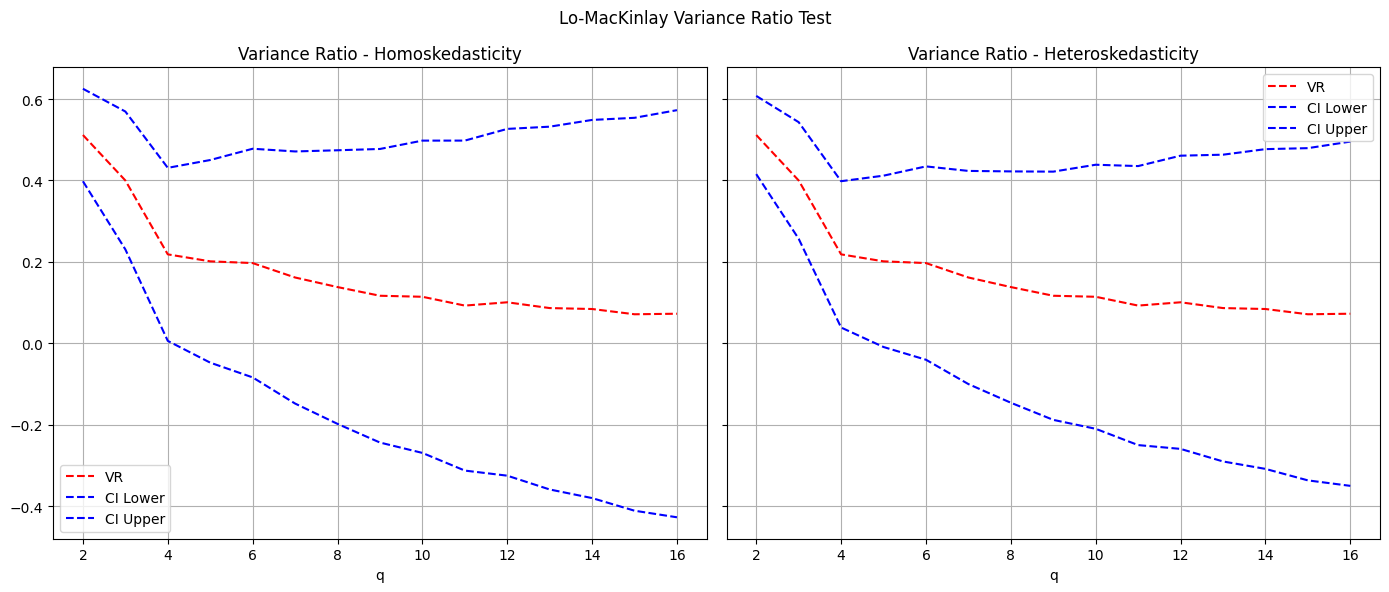

q        VR         z    z_star    z_crit  lower_homo  upper_homo  \
0    2  0.511659 -8.430081 -9.969888  1.959964    0.398121    0.625196   
1    3  0.400049 -6.947527 -8.216536  1.959964    0.230797    0.569301   
2    4  0.218629 -7.209934 -8.526873  1.959964    0.006220    0.431039   
3    5  0.201514 -6.291510 -7.440693  1.959964   -0.047235    0.450262   
4    6  0.197260 -5.605613 -6.629513  1.959964   -0.083413    0.477932   
5    7  0.161842 -5.308618 -6.278270  1.959964   -0.147610    0.471293   
6    8  0.138338 -5.028531 -5.947023  1.959964   -0.197511    0.474187   
7    9  0.117018 -4.802389 -5.679575  1.959964   -0.243347    0.477383   
8   10  0.114540 -4.527150 -5.354062  1.959964   -0.268808    0.497887   
9   11  0.092880 -4.389400 -5.191152  1.959964   -0.312169    0.497929   
10  12  0.100985 -4.139528 -4.895639  1.959964   -0.324676    0.526647   
11  13  0.086782 -4.019195 -4.753326  1.959964   -0.358549    0.532114   
12  14  0.084478 -3.865743 -4.571845  1.959964   -0.379699    0.548655   
13  15  0.071582 -3.772941 -4.462092  1.959964   -0.410712    0.553876   
14  16  0.072893 -3.635943 -4.300070  1.959964   -0.426866    0.572652   

    lower_hetero  upper_hetero        Decision  
0       0.415656      0.607661  Reject Both RW  
1       0.256937      0.543161  Reject Both RW  
2       0.039025      0.398233  Reject Both RW  
3      -0.008817      0.411844  Reject Both RW  
4      -0.040064      0.434584  Reject Both RW  
5      -0.099816      0.423500  Reject Both RW  
6      -0.145641      0.422316  Reject Both RW  
7      -0.187690      0.421726  Reject Both RW  
8      -0.209601      0.438680  Reject Both RW  
9      -0.249611      0.435371  Reject Both RW  
10     -0.258934      0.460905  Reject Both RW  
11     -0.289769      0.463334  Reject Both RW  
12     -0.308009      0.476965  Reject Both RW  
13     -0.336224      0.479387  Reject Both RW  
14     -0.349680      0.495467  Reject Both RW

In [ ]:
variance_ratio_test(palantir_log, price_column='Close', q_max=16, alpha=0.05)

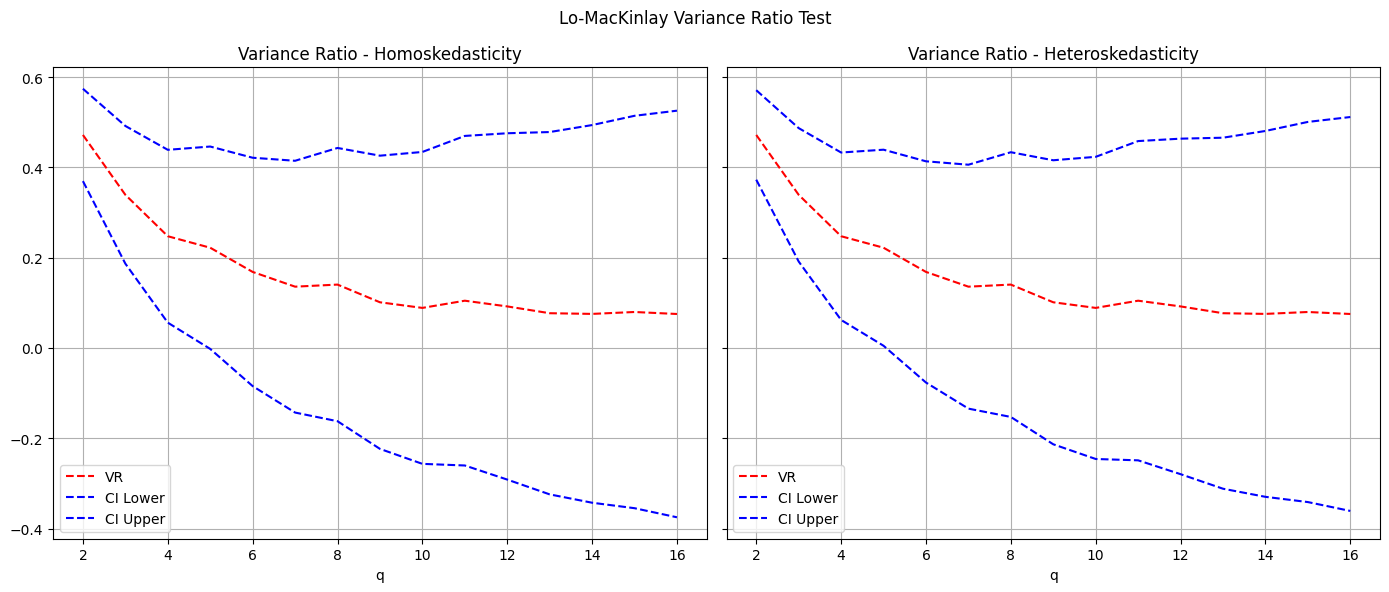

q        VR          z     z_star    z_crit  lower_homo  upper_homo  \
0    2  0.471753 -10.119766 -10.446097  1.959964    0.369443    0.574062   
1    3  0.339161  -8.492486  -8.766342  1.959964    0.186648    0.491675   
2    4  0.247412  -7.706480  -7.954991  1.959964    0.056009    0.438816   
3    5  0.221940  -6.803393  -7.022781  1.959964   -0.002208    0.446088   
4    6  0.168351  -6.444856  -6.652683  1.959964   -0.084565    0.421266   
5    7  0.135691  -6.075044  -6.270946  1.959964   -0.143157    0.414539   
6    8  0.140299  -5.567708  -5.747249  1.959964   -0.162336    0.442934   
7    9  0.101102  -5.425516  -5.600473  1.959964   -0.223625    0.425828   
8   10  0.088642  -5.170944  -5.337691  1.959964   -0.256794    0.434078   
9   11  0.104596  -4.808221  -4.963271  1.959964   -0.260396    0.469587   
10  12  0.091941  -4.640054  -4.789681  1.959964   -0.291624    0.475506   
11  13  0.076887  -4.508628  -4.654018  1.959964   -0.324403    0.478177   
12  14  0.075373  -4.332670  -4.472385  1.959964   -0.342899    0.493645   
13  15  0.079587  -4.150919  -4.284773  1.959964   -0.355011    0.514184   
14  16  0.075175  -4.025053  -4.154849  1.959964   -0.375160    0.525510   

    lower_hetero  upper_hetero        Decision  
0       0.372639      0.570866  Reject Both RW  
1       0.191412      0.486910  Reject Both RW  
2       0.061989      0.432836  Reject Both RW  
3       0.004794      0.439086  Reject Both RW  
4      -0.076664      0.413365  Reject Both RW  
5      -0.134446      0.405828  Reject Both RW  
6      -0.152882      0.433480  Reject Both RW  
7      -0.213481      0.415684  Reject Both RW  
8      -0.246003      0.423286  Reject Both RW  
9      -0.248993      0.458185  Reject Both RW  
10     -0.279642      0.463524  Reject Both RW  
11     -0.311867      0.465641  Reject Both RW  
12     -0.329832      0.480579  Reject Both RW  
13     -0.341434      0.500607  Reject Both RW  
14     -0.361092      0.511442  Reject Both RW

In [ ]:
variance_ratio_test(gold_log, price_column='Close', q_max=16, alpha=0.05)

# **NEGATIVE PARETO TAIL**


--- Analiză pentru seria: Solana ---
Media: 0.003056
Deviația standard: 0.065847
Percentila 1% (q): -0.167840
Calculating best minimal value for power law fit
Estimated tail index alpha = 4.230
Estimated x_min = 0.200


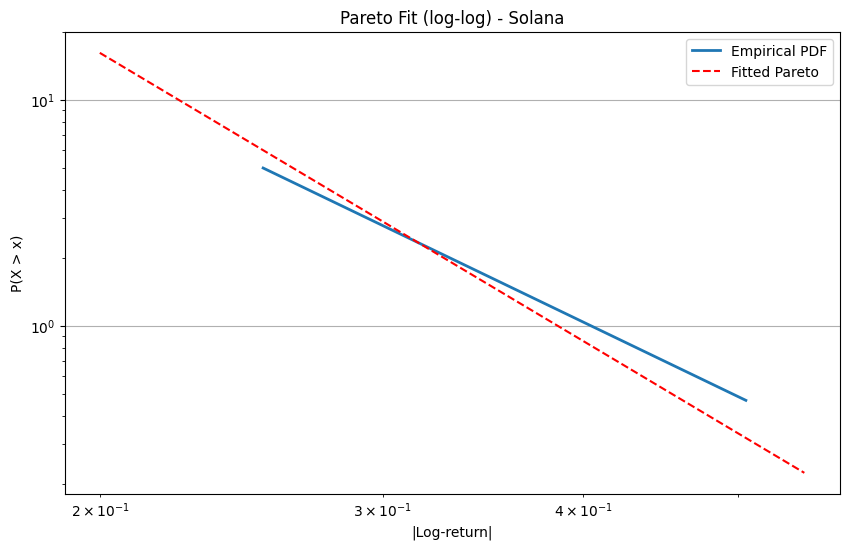

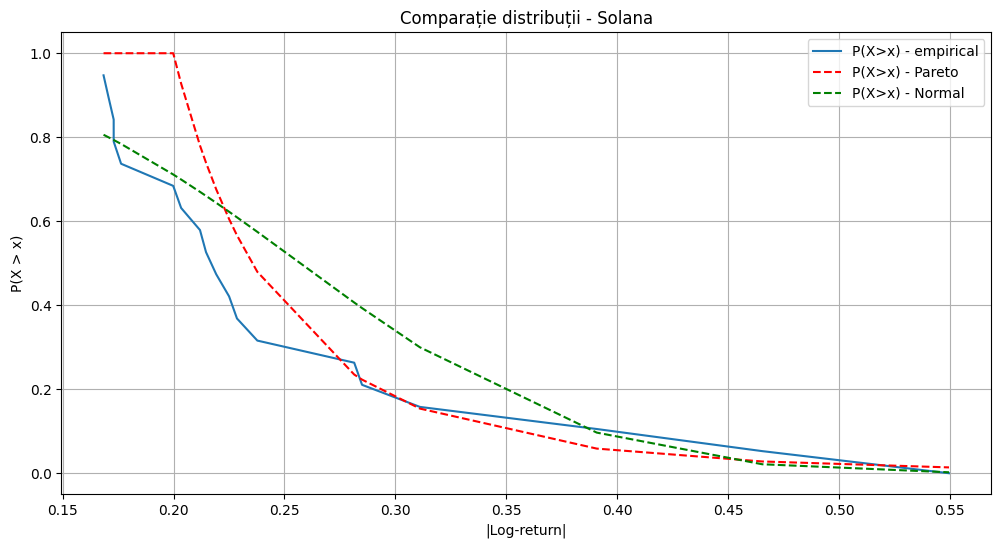

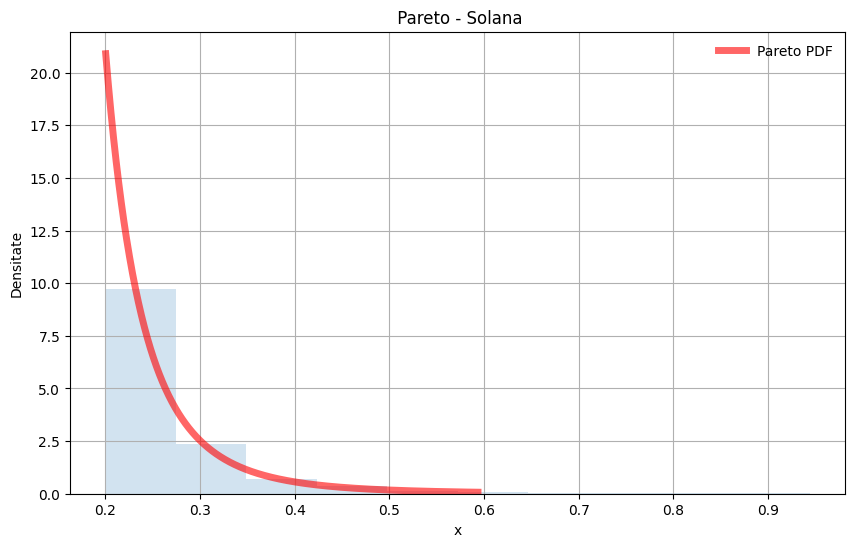

In [ ]:
def analyze_tail_pareto(df, column='Close', series_name=None):
    """
    Analyzes the left tail of the log-return distribution using the Pareto distribution.
    Displays the estimates and associated plots.

    Parameters:
        df (pd.DataFrame): DataFrame containing the column with log-returns or prices.
        column (str): Name of the column containing the values.
        series_name (str): Display name for the series (optional).
    """
    if series_name is None:
        series_name = column

    log_returns = df[column]

    # Basic descriptive statistics
    q = log_returns.quantile(0.01).item()
    mu = log_returns.mean(axis=0).item()
    sigma = log_returns.std(axis=0).item()

    print(f"\n--- Analysis for series: {series_name} ---")
    print(f"Mean: {mu:.6f}")
    print(f"Standard deviation: {sigma:.6f}")
    print(f"1% percentile (q): {q:.6f}")

    # Select left tail (lowest 1% values)
    x = log_returns[log_returns <= q].dropna()
    y = abs(x)

    # Convert to numpy array
    z = y.values.ravel()

    # Fit power-law (Pareto) distribution
    fit = powerlaw.Fit(z)
    alpha = fit.alpha
    xmin = fit.xmin

    print(f'Estimated tail index alpha = {alpha:.3f}')
    print(f'Estimated x_min = {xmin:.3f}')

    # === PLOT 1: Log-log plot with empirical PDF vs. Pareto ===
    plt.figure(figsize=(10,6))
    powerlaw.plot_pdf(z, linewidth=2, label='Empirical PDF')
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Fitted Pareto')
    plt.legend()
    plt.title(f"Pareto Fit (log-log) - {series_name}")
    plt.xlabel('|Log-return|')
    plt.ylabel('P(X > x)')
    plt.grid(True)
    plt.show()

    # === PLOT 2: P(X>x) empirical vs. Pareto vs. Normal ===
    xs = np.sort(z)
    ys = 1 - np.arange(1, len(xs) + 1) / float(len(xs))
    zs = 1 - pareto.cdf(xs, alpha, loc=0, scale=xmin)
    vs = 1 - norm.cdf(xs, np.mean(z), np.std(z))

    plt.figure(figsize=(12,6))
    plt.plot(xs, ys, label='P(X>x) - empirical')
    plt.plot(xs, zs, linestyle='--', color='r', label='P(X>x) - Pareto')
    plt.plot(xs, vs, linestyle='--', color='g', label='P(X>x) - Normal')
    plt.legend()
    plt.xlabel('|Log-return|')
    plt.ylabel('P(X > x)')
    plt.title(f'Distribution Comparison - {series_name}')
    plt.grid(True)
    plt.show()

    # === PLOT 3: Estimated Pareto ===
    r = pareto.rvs(alpha, size=1000, loc=0, scale=xmin)
    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    x_vals = np.linspace(
        pareto.ppf(0.01, alpha, loc=0, scale=xmin),
        pareto.ppf(0.99, alpha, loc=0, scale=xmin),
        1000
    )

    ax.plot(x_vals, pareto.pdf(x_vals, alpha, loc=0, scale=xmin),
            'r-', lw=5, alpha=0.6, label='Pareto PDF')
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
    ax.legend(loc='best', frameon=False)
    ax.set_title(f" Pareto - {series_name}")
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

analyze_tail_pareto(solana_log, series_name="Solana")



--- Analiză pentru seria: Palantir ---
Media: 0.002233
Deviația standard: 0.045102
Percentila 1% (q): -0.107517
Calculating best minimal value for power law fit
Estimated tail index alpha = 5.527
Estimated x_min = 0.111


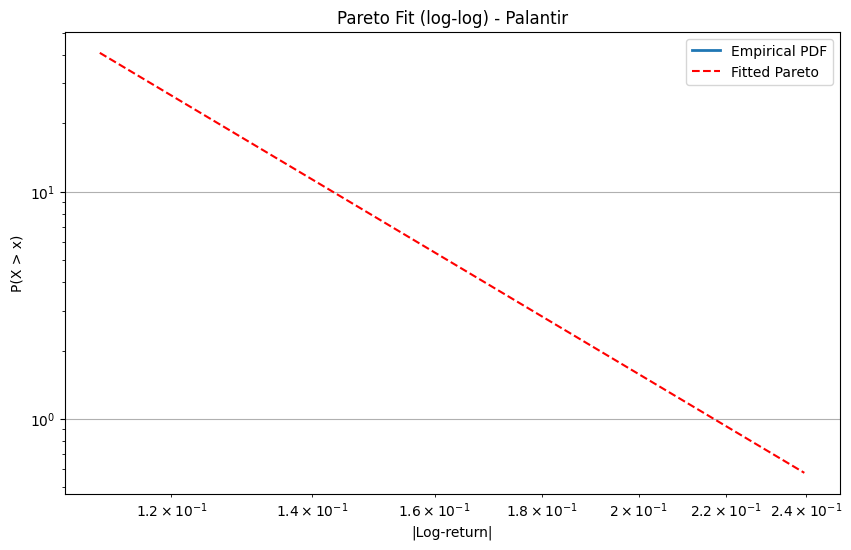

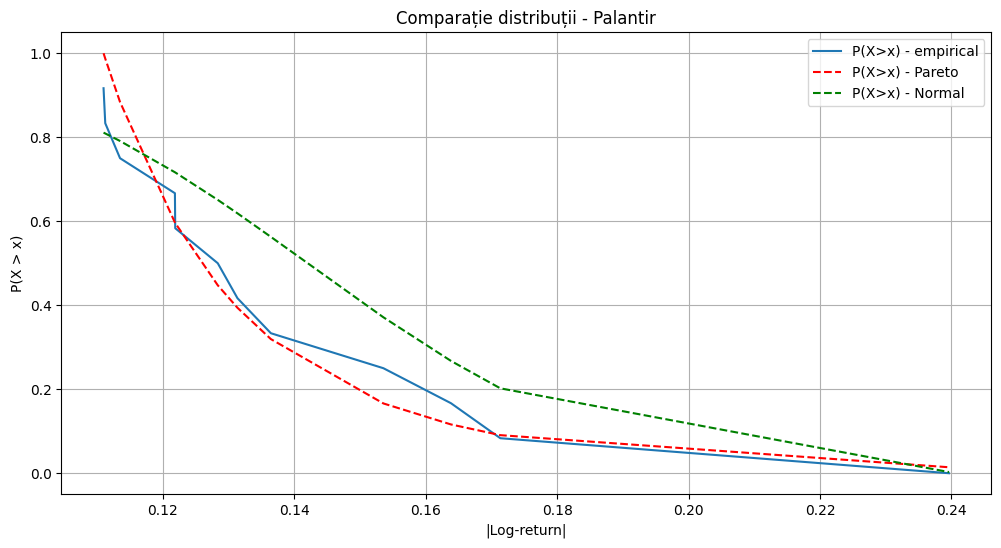

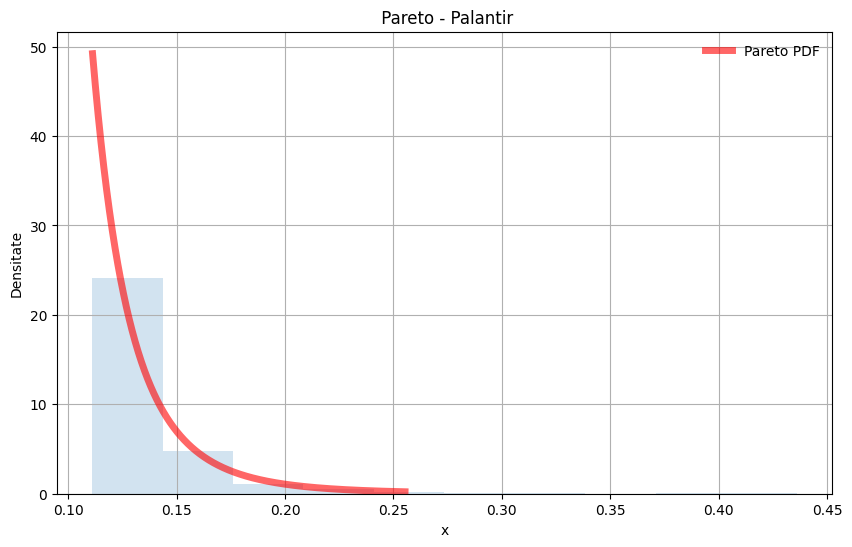

In [ ]:
analyze_tail_pareto(palantir_log, series_name="Palantir")


--- Analiză pentru seria: Gold ---
Media: 0.000542
Deviația standard: 0.009972
Percentila 1% (q): -0.027324
Calculating best minimal value for power law fit
Estimated tail index alpha = 5.134
Estimated x_min = 0.028


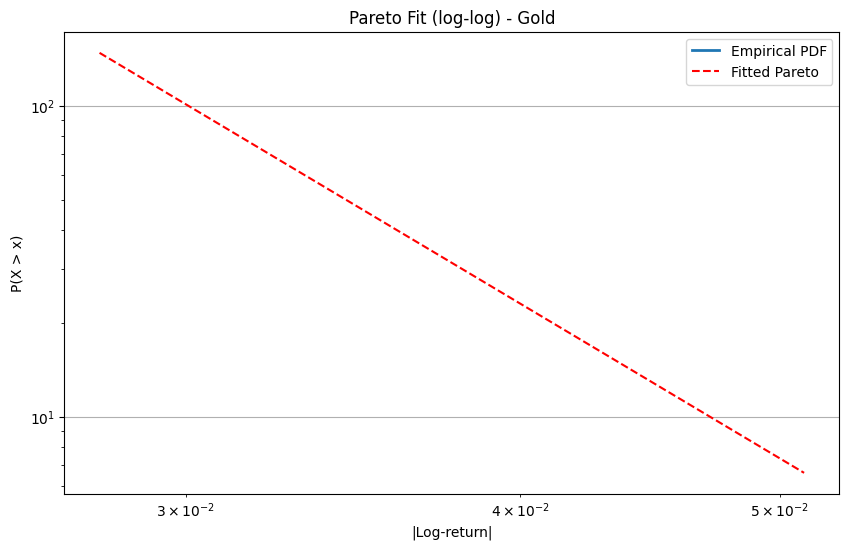

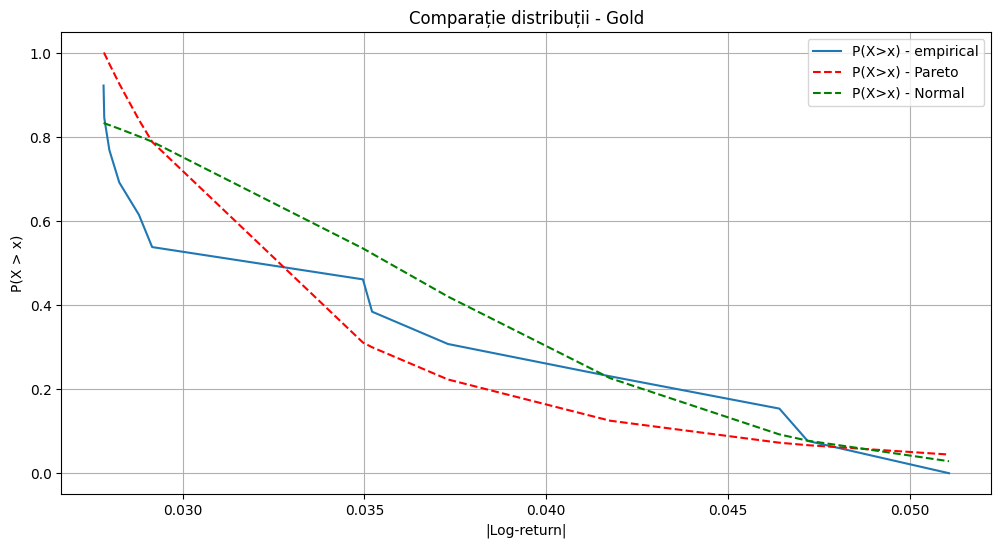

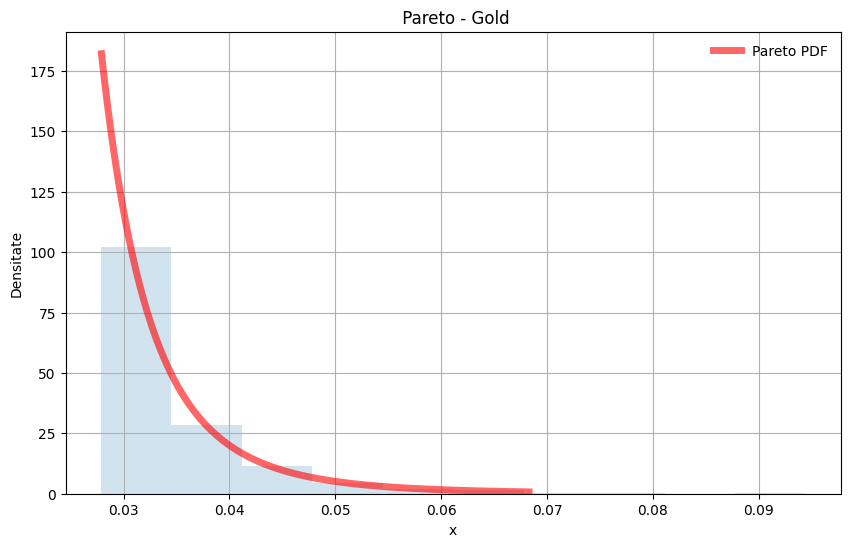

In [ ]:
analyze_tail_pareto(gold_log, series_name="Gold")

# **ROLLING VALUE AT RISK**

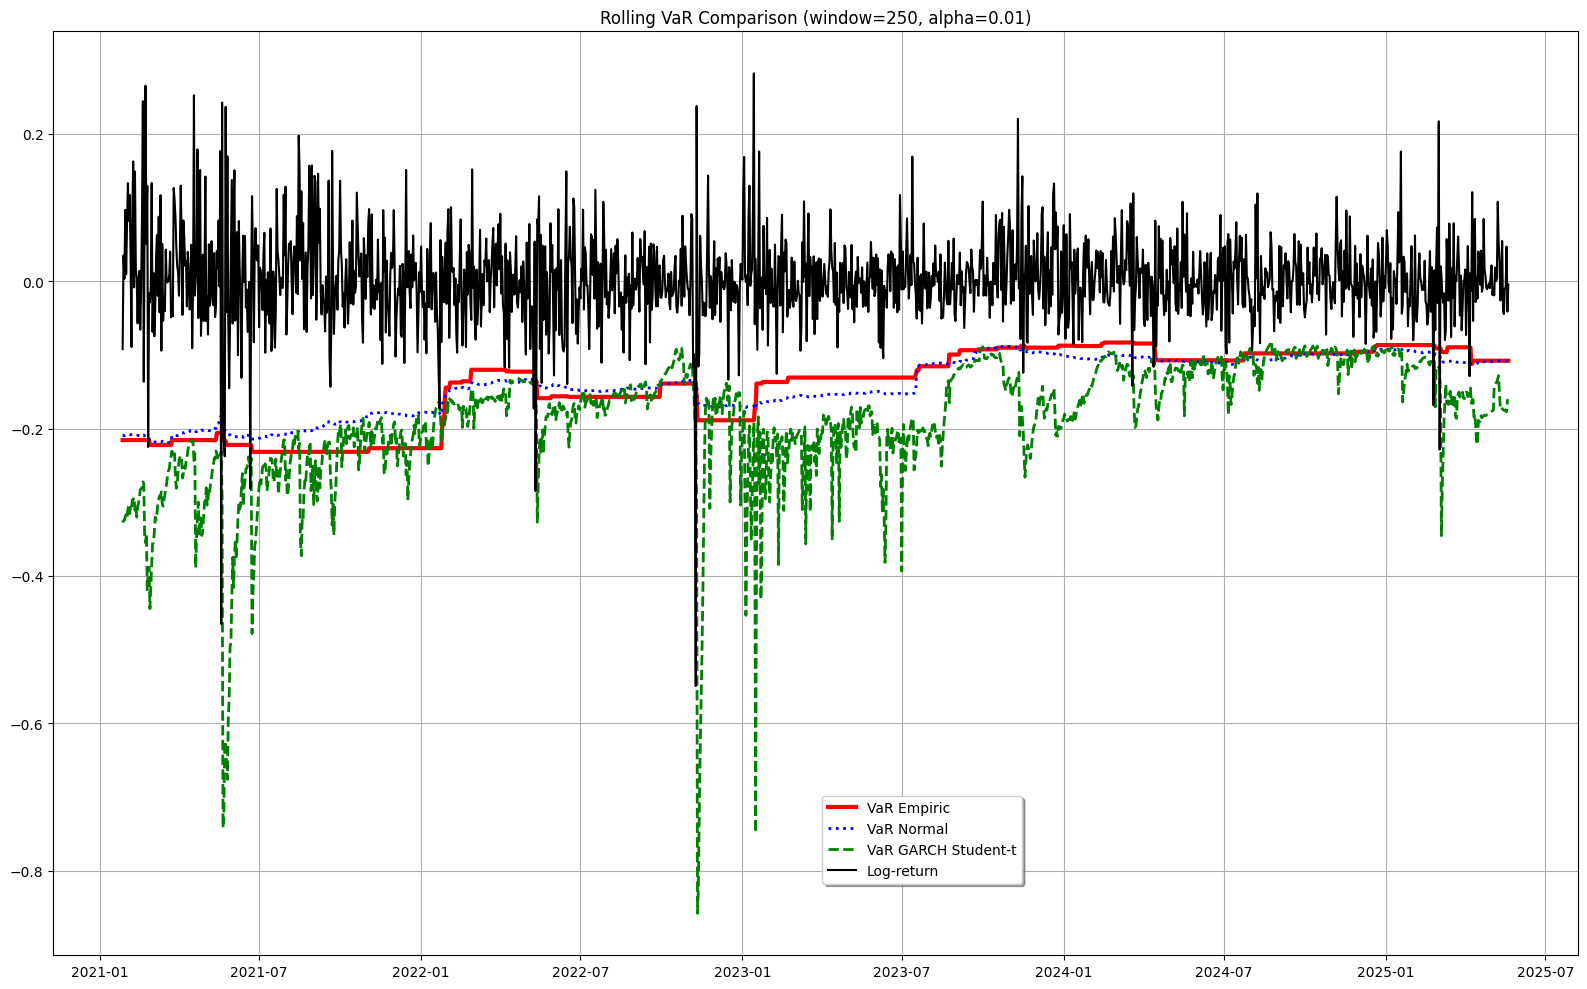

VaR_empiric  VaR_normal     VaR_t             VaR_GARCH_n  \
Date                                                                    
2021-01-27    -0.215720   -0.209257 -0.331597  [-0.20706296044353814]   
2021-01-28    -0.215720   -0.209348 -0.329110  [-0.20647311417041708]   
2021-01-29    -0.215720   -0.209931 -0.327319  [-0.20806454358400983]   
2021-01-30    -0.215720   -0.208691 -0.328955  [-0.20127513637248318]   
2021-01-31    -0.215720   -0.208698 -0.333540   [-0.1941186739949153]   
...                 ...         ...       ...                     ...   
2025-05-16    -0.107943   -0.107811 -0.174685   [-0.1025725572461849]   
2025-05-17    -0.107943   -0.108242 -0.173764  [-0.10418350743625572]   
2025-05-18    -0.107943   -0.108310 -0.175665   [-0.1012988815861306]   
2025-05-19    -0.107943   -0.108369 -0.175690   [-0.0986858549941788]   
2025-05-20    -0.107943   -0.108238 -0.174033  [-0.10006581682015556]   

                       VaR_GARCH_t  Actual_Return  
Date                                               
2021-01-27   [-0.3275073301904594]      -0.092277  
2021-01-28   [-0.3251485773202889]       0.035007  
2021-01-29   [-0.3244924721316381]       0.003292  
2021-01-30  [-0.31963314805488324]       0.096763  
2021-01-31  [-0.31675467505140076]       0.009394  
...                            ...            ...  
2025-05-16  [-0.17526371201567068]      -0.009966  
2025-05-17   [-0.1746910599894088]      -0.008421  
2025-05-18  [-0.17737258860156616]       0.046902  
2025-05-19   [-0.1615132433941345]      -0.041293  
2025-05-20   [-0.1619557547828549]      -0.004500  

[1575 rows x 6 columns]

In [ ]:
def compute_rolling_var_garch(log_returns, window=250, alpha=0.01):
    """
    Estimates Value at Risk (VaR) using multiple methods, including GARCH.

    Parameters:
    - log_returns: Series or array with log-returns (1D)
    - window: rolling window size (e.g., 250)
    - alpha: significance level (e.g., 0.01)

    Returns:
    - DataFrame with VaR estimates and actual log-returns
    """

    if isinstance(log_returns, (pd.DataFrame, pd.Series)):
        log_returns = log_returns.squeeze()
    log_returns = pd.Series(log_returns).dropna().replace([np.inf, -np.inf], np.nan).dropna()
    log_returns_values = log_returns.to_numpy()

    VaR_empiric, VaR_normal, VaR_t = [], [], []
    VaR_GARCH_n, VaR_GARCH_t = [], []

    iterations = len(log_returns_values) - window

    for i in range(1, iterations):
        ret = log_returns_values[i:(window + i - 1)]
        if len(ret) < 10:
            continue  # skip windows that are too short

        mu, sigma = ret.mean(), ret.std()

        # VaR Normal
        v_normal = norm.ppf(alpha) * sigma + mu
        VaR_normal.append(v_normal)

        # VaR Student-t
        nu = t.fit(ret)[0]
        v_t = t.ppf(alpha, nu) * sigma + mu
        VaR_t.append(v_t)

        # VaR Empirical
        v_empiric = np.quantile(ret, alpha)
        VaR_empiric.append(v_empiric)

        # VaR GARCH Normal
        model_norm = arch_model(ret * 100, vol='GARCH', p=1, q=1)
        fit_norm = model_norm.fit(disp=0)
        yhat = fit_norm.forecast(horizon=1)
        var_n = 0.01 * np.sqrt(yhat.variance.values[-1]) * norm.ppf(alpha) + mu
        VaR_GARCH_n.append(var_n)

        # VaR GARCH Student-t
        model_t = arch_model(ret * 100, vol='GARCH', p=1, q=1, dist='StudentsT')
        fit_t = model_t.fit(disp=0)
        df_t = fit_t.params['nu']
        yhat = fit_t.forecast(horizon=1)
        var_t = 0.01 * np.sqrt(yhat.variance.values[-1]) * t.ppf(alpha, df_t) + mu
        VaR_GARCH_t.append(var_t)

    # Prepare results
    actual_returns = log_returns_values[(window + 1):(window + 1 + len(VaR_empiric))]
    dates = log_returns.index[(window + 1):(window + 1 + len(VaR_empiric))]

    # Plot results
    plt.figure(figsize=(16, 10))
    plt.plot(dates, VaR_empiric, label='VaR Empirical', c='red', linewidth=3)
    plt.plot(dates, VaR_normal, label='VaR Normal', c='blue', linestyle='dotted', linewidth=2)
    plt.plot(dates, VaR_GARCH_t, label='VaR GARCH Student-t', c='green', linestyle='dashed', linewidth=2)
    plt.plot(dates, actual_returns, label='Log-return', c='black')
    plt.legend(loc='lower left', bbox_to_anchor=(0.5, 0.07), fancybox=True, shadow=True)
    plt.title(f"Rolling VaR Comparison (window={window}, alpha={alpha})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return as DataFrame
    return pd.DataFrame({
        'VaR_empiric': VaR_empiric,
        'VaR_normal': VaR_normal,
        'VaR_t': VaR_t,
        'VaR_GARCH_n': VaR_GARCH_n,
        'VaR_GARCH_t': VaR_GARCH_t,
        'Actual_Return': actual_returns
    }, index=dates)

compute_rolling_var_garch(solana_log['Close'])

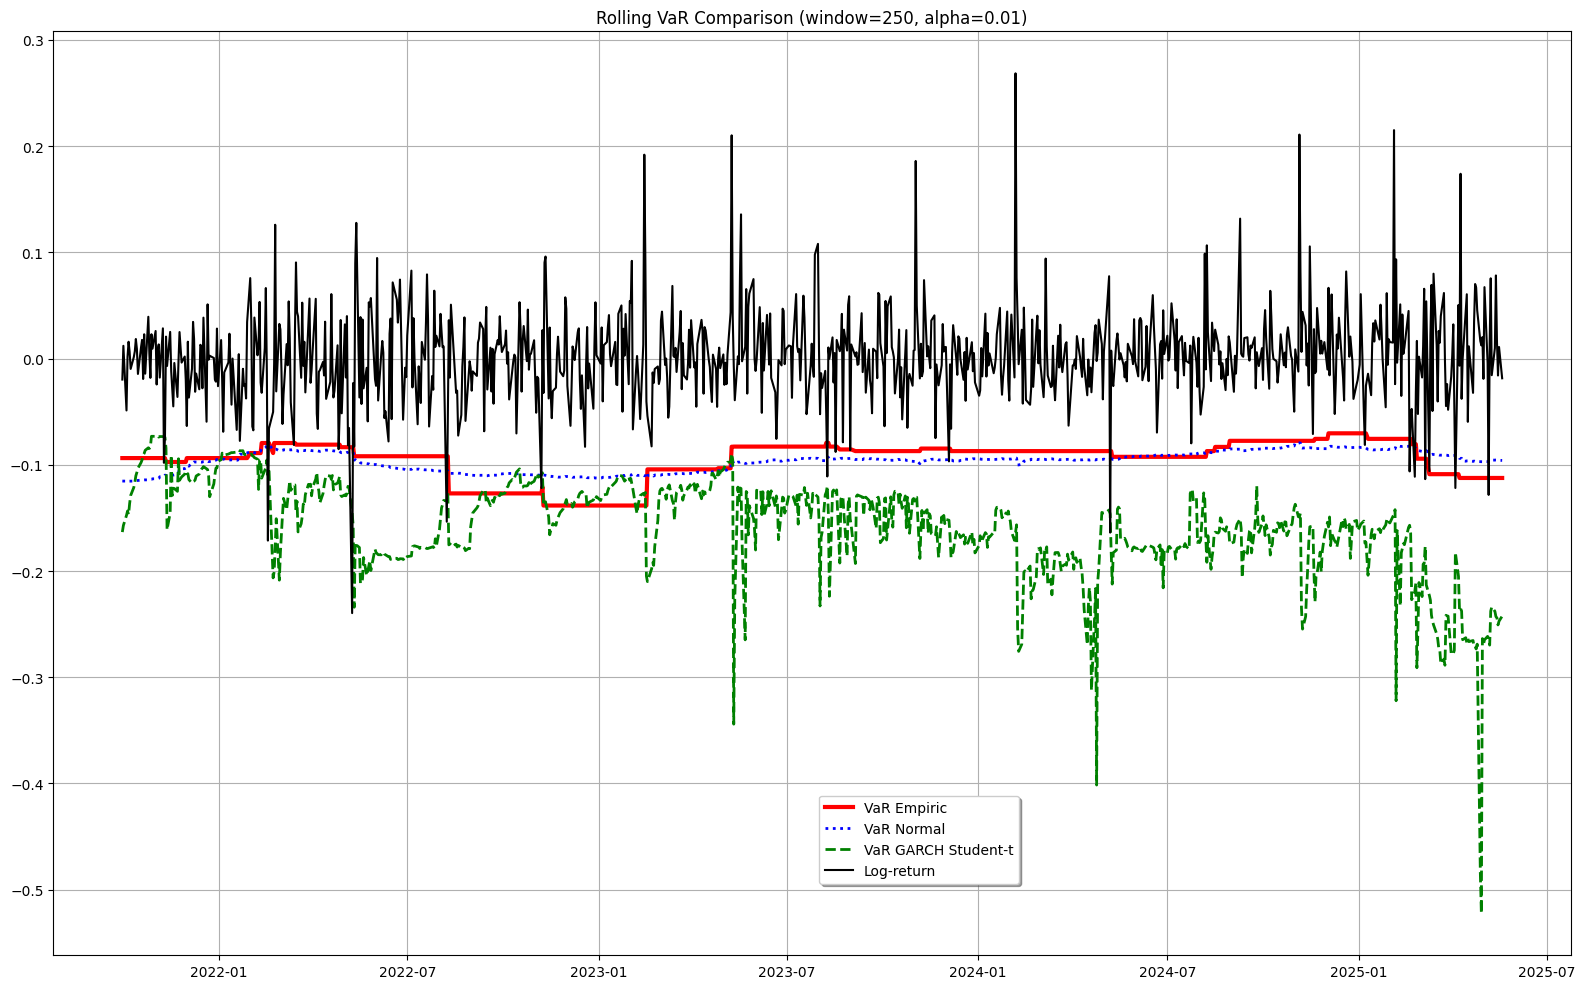

VaR_empiric  VaR_normal     VaR_t             VaR_GARCH_n  \
Date                                                                    
2021-09-30    -0.093696   -0.115302 -0.221529  [-0.09112722784184543]   
2021-10-01    -0.093696   -0.115353 -0.221019  [-0.08969017864826961]   
2021-10-04    -0.093696   -0.115363 -0.220920  [-0.08650914880572184]   
2021-10-05    -0.093696   -0.114979 -0.222382  [-0.08583585082857405]   
2021-10-06    -0.093696   -0.115463 -0.219979  [-0.08721818049670393]   
...                 ...         ...       ...                     ...   
2025-05-13    -0.112413   -0.095504 -0.204252   [-0.1275323626254568]   
2025-05-14    -0.112413   -0.095522 -0.204886  [-0.12717991283160468]   
2025-05-15    -0.112413   -0.095809 -0.204392  [-0.12734398055814236]   
2025-05-16    -0.112413   -0.095794 -0.203842  [-0.12676415868891264]   
2025-05-19    -0.112413   -0.095904 -0.202223   [-0.1264036931303482]   

                       VaR_GARCH_t  Actual_Return  
Date                                               
2021-09-30  [-0.16334519794166677]      -0.019770  
2021-10-01  [-0.15715257582889053]       0.011991  
2021-10-04  [-0.14759962844087773]      -0.048852  
2021-10-05   [-0.1435547700376876]       0.001725  
2021-10-06  [-0.14683866828968212]       0.015816  
...                            ...            ...  
2025-05-13  [-0.24292353509548256]       0.078236  
2025-05-14  [-0.24417462228585346]       0.016107  
2025-05-15   [-0.2507466157263942]      -0.015951  
2025-05-16  [-0.24724609335915068]       0.010868  
2025-05-19  [-0.24245967540817423]      -0.018586  

[912 rows x 6 columns]

In [ ]:
compute_rolling_var_garch(palantir_log['Close'])

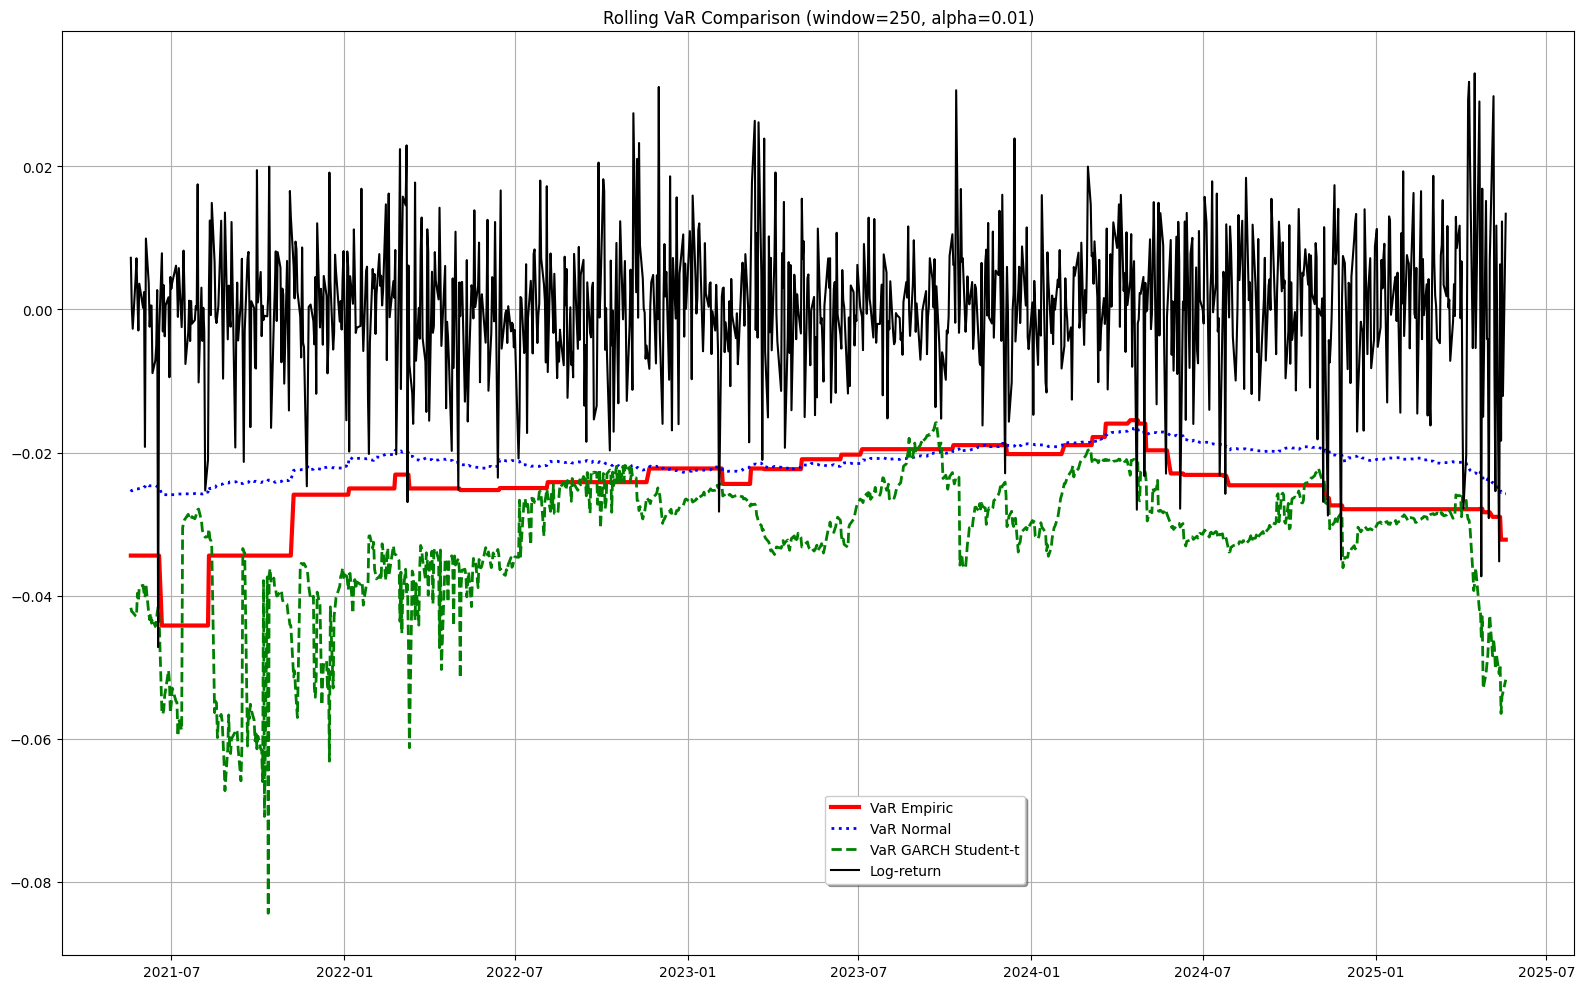

VaR_empiric  VaR_normal     VaR_t              VaR_GARCH_n  \
Date                                                                     
2021-05-19    -0.034403   -0.025478 -0.040659  [-0.026017264929217212]   
2021-05-20    -0.034403   -0.025276 -0.041041   [-0.02374801245979572]   
2021-05-21    -0.034403   -0.025274 -0.041106  [-0.023229353078708253]   
2021-05-24    -0.034403   -0.025070 -0.041471  [-0.021787121276097915]   
2021-05-25    -0.034403   -0.025094 -0.041310  [-0.021162563939237634]   
...                 ...         ...       ...                      ...   
2025-05-13    -0.028991   -0.024890 -0.036294   [-0.03953376160689383]   
2025-05-14    -0.032178   -0.025592 -0.038339   [-0.04603779564430756]   
2025-05-15    -0.032178   -0.025561 -0.038719   [-0.04325949338725737]   
2025-05-16    -0.032178   -0.025765 -0.038559  [-0.043013617723582344]   
2025-05-19    -0.032178   -0.025759 -0.038603   [-0.04107751274898832]   

                        VaR_GARCH_t  Actual_Return  
Date                                                
2021-05-19   [-0.04170015894539165]       0.007202  
2021-05-20   [-0.04224140421331651]       0.000266  
2021-05-21   [-0.04232095783633311]      -0.002714  
2021-05-24   [-0.04282065067366138]       0.004201  
2021-05-25   [-0.04290594067162845]       0.007138  
...                             ...            ...  
2025-05-13   [-0.04961013328936978]       0.006285  
2025-05-14  [-0.056463013515671706]      -0.018345  
2025-05-15  [-0.054094466886898174]       0.012277  
2025-05-16  [-0.053534930603070546]      -0.012089  
2025-05-19   [-0.05174462485279156]       0.013361  

[1006 rows x 6 columns]

In [ ]:
compute_rolling_var_garch(gold_log['Close'])

# **ACF/PACF**

In [ ]:
def plot_acf_pacf(series, lags=20, title_prefix='Series'):
    """
    Plots ACF and PACF for a time series (e.g., log-returns).

    Parameters:
    - series: pd.Series or np.ndarray (1D) with input data
    - lags: number of lags for ACF and PACF
    - title_prefix: prefix for plot titles (e.g., 'S&P 500')
    """
    plt.figure(figsize=(10, 5))
    plot_acf(series, lags=lags, markersize=4)
    plt.title(f'ACF - {title_prefix}')
    plt.show()

    plt.figure(figsize=(10, 5))
    plot_pacf(series, lags=lags, markersize=4)
    plt.title(f'PACF - {title_prefix}')
    plt.show()

# **ARIMA-GARCH SOLANA**

<Figure size 1000x500 with 0 Axes>

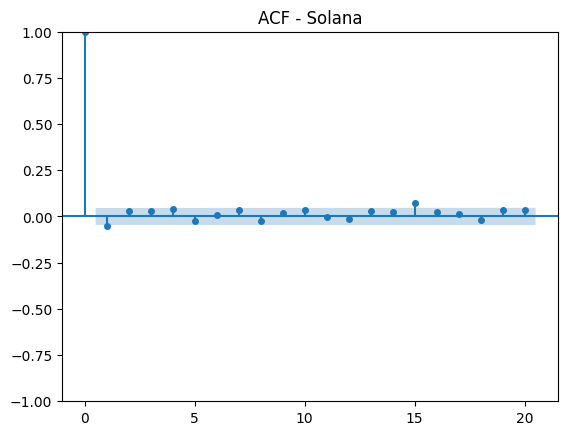

<Figure size 1000x500 with 0 Axes>

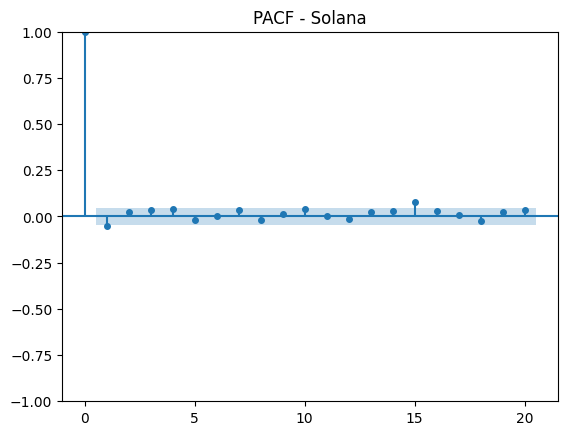

In [ ]:
plot_acf_pacf(solana_log['Close'], title_prefix='Solana')

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def testeaza_modele_arima(serie, p_max=3, d=0, q_max=3):
    rezultate = []

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")

                    model = ARIMA(serie, order=(p, d, q))
                    fitted = model.fit()
                    resid = fitted.resid.dropna()

                    rezultate.append({
                        'Model': f'ARIMA({p},{d},{q})',
                        'AIC': fitted.aic,
                        'BIC': fitted.bic,
                        'HQIC': fitted.hqic,
                        'LogLik': fitted.llf,
                        'Num_Params': len(fitted.params),
                        'Sigma2': np.var(resid, ddof=1),
                        'Skewness': skew(resid),
                        'Kurtosis': kurtosis(resid),
                    })

            except Exception as e:
                continue

    df_rezultate = pd.DataFrame(rezultate)
    df_rezultate = df_rezultate.sort_values(by='AIC')
    return df_rezultate

#ARIMA Tester
df_arima = testeaza_modele_arima(solana_log['Close'], p_max=3, d=0, q_max=3)
df_arima.head(20)

Model          AIC          BIC         HQIC       LogLik  \
9   ARIMA(2,0,1) -4750.499576 -4722.950161 -4740.337377  2380.249788   
6   ARIMA(1,0,2) -4750.383677 -4722.834262 -4740.221478  2380.191838   
13  ARIMA(3,0,1) -4748.200713 -4715.141415 -4736.006074  2380.100356   
14  ARIMA(3,0,2) -4746.509109 -4707.939927 -4732.282030  2380.254554   
4   ARIMA(1,0,0) -4745.091021 -4728.561372 -4738.993701  2375.545510   
1   ARIMA(0,0,1) -4744.828765 -4728.299116 -4738.731445  2375.414382   
3   ARIMA(0,0,3) -4744.814145 -4717.264730 -4734.651946  2377.407073   
2   ARIMA(0,0,2) -4744.593192 -4722.553660 -4736.463433  2376.296596   
8   ARIMA(2,0,0) -4744.354166 -4722.314634 -4736.224407  2376.177083   
12  ARIMA(3,0,0) -4744.299299 -4716.749884 -4734.137100  2377.149649   
10  ARIMA(2,0,2) -4744.076086 -4711.016788 -4731.881447  2378.038043   
5   ARIMA(1,0,1) -4743.620041 -4721.580509 -4735.490282  2375.810021   
7   ARIMA(1,0,3) -4743.307958 -4710.248659 -4731.113319  2377.653979   
0   ARIMA(0,0,0) -4742.335041 -4731.315275 -4738.270162  2373.167521   
11  ARIMA(2,0,3) -4741.400194 -4702.831013 -4727.173116  2377.700097   
15  ARIMA(3,0,3) -4740.185451 -4696.106387 -4723.925933  2378.092726   

    Num_Params    Sigma2  Skewness  Kurtosis  
9            5  0.004320 -0.303857  7.320883  
6            5  0.004321 -0.307206  7.330492  
13           6  0.004321 -0.300008  7.329053  
14           7  0.004320 -0.302070  7.317658  
4            3  0.004343 -0.261085  7.266407  
1            3  0.004343 -0.261699  7.265963  
3            5  0.004334 -0.249794  7.181780  
2            4  0.004339 -0.245735  7.216864  
8            4  0.004340 -0.245743  7.221900  
12           5  0.004335 -0.247759  7.176187  
10           6  0.004331 -0.251043  7.217430  
5            4  0.004342 -0.256903  7.258653  
7            6  0.004333 -0.250829  7.191373  
0            2  0.004354 -0.246766  7.196692  
11           7  0.004333 -0.251258  7.187542  
15           8  0.004331 -0.249057  7.225897

In [ ]:
best_model_solana_arima = ARIMA(solana_log['Close'], order=( 2, 0, 1))
best_fitted_solana = best_model_solana_arima.fit()
print(best_fitted_solana.summary())

r_solana = best_fitted_solana.resid
r_solana.head()

rsq_solana = r_solana**2
rsq_solana.head()

                               SARIMAX Results                                
Dep. Variable:                SOL-USD   No. Observations:                 1826
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2380.250
Date:                Mon, 19 May 2025   AIC                          -4750.500
Time:                        14:55:59   BIC                          -4722.950
Sample:                    05-20-2020   HQIC                         -4740.337
                         - 05-19-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.319      0.187      -0.001       0.008
ar.L1          0.8899      0.034     26.174      0.000       0.823       0.957
ar.L2          0.0719      0.016      4.374      0.0

Date
2020-05-20    0.006138
2020-05-21    0.001854
2020-05-22    0.002422
2020-05-23    0.001721
2020-05-24    0.013472
dtype: float64

# **ARIMA-GARCH PALANTIR**

<Figure size 1000x500 with 0 Axes>

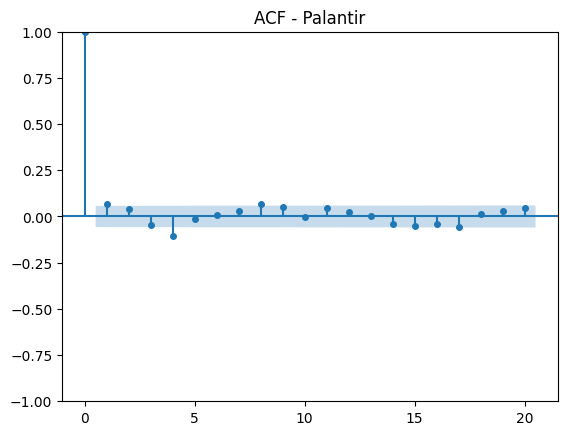

<Figure size 1000x500 with 0 Axes>

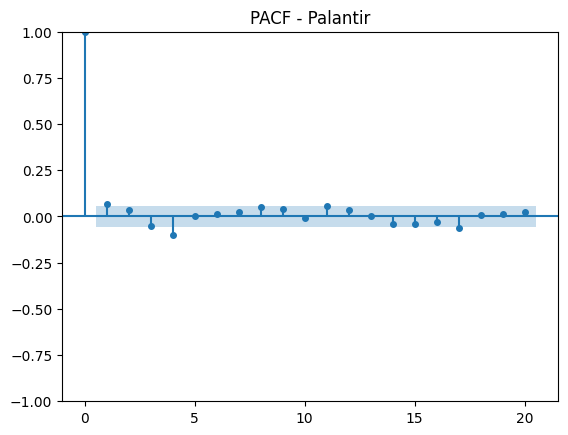

In [ ]:
plot_acf_pacf(palantir_log['Close'], title_prefix='Palantir')

In [ ]:
df_arima = testeaza_modele_arima(palantir_log['Close'], p_max=3, d=0, q_max=3)
df_arima.head(20)

Model          AIC          BIC         HQIC       LogLik  \
11  ARIMA(2,0,3) -3908.618005 -3873.206698 -3895.258237  1961.309002   
14  ARIMA(3,0,2) -3908.418007 -3873.006700 -3895.058239  1961.209003   
10  ARIMA(2,0,2) -3908.381099 -3878.028550 -3896.929870  1960.190550   
15  ARIMA(3,0,3) -3904.771575 -3864.301510 -3889.503269  1960.385788   
13  ARIMA(3,0,1) -3904.338332 -3873.985783 -3892.887102  1958.169166   
7   ARIMA(1,0,3) -3903.014116 -3872.661567 -3891.562887  1957.507058   
2   ARIMA(0,0,2) -3901.847916 -3881.612884 -3894.213763  1954.923958   
12  ARIMA(3,0,0) -3901.507868 -3876.214077 -3891.965176  1955.753934   
4   ARIMA(1,0,0) -3901.065574 -3885.889300 -3895.339959  1953.532787   
3   ARIMA(0,0,3) -3900.786862 -3875.493071 -3891.244171  1955.393431   
8   ARIMA(2,0,0) -3900.706245 -3880.471213 -3893.072092  1954.353123   
1   ARIMA(0,0,1) -3900.631964 -3885.455689 -3894.906349  1953.315982   
6   ARIMA(1,0,2) -3900.046051 -3874.752261 -3890.503360  1955.023026   
5   ARIMA(1,0,1) -3899.573619 -3879.338586 -3891.939466  1953.786809   
9   ARIMA(2,0,1) -3899.156232 -3873.862442 -3889.613541  1954.578116   
0   ARIMA(0,0,0) -3897.514387 -3887.396871 -3893.697311  1950.757194   

    Num_Params    Sigma2  Skewness  Kurtosis  
11           7  0.002009  0.604842  4.334390  
14           7  0.002010  0.605430  4.332980  
10           6  0.002013  0.600949  4.380878  
15           8  0.002013  0.597805  4.334807  
13           6  0.002020  0.618578  4.355491  
7            6  0.002023  0.623163  4.362792  
2            4  0.002032  0.631198  4.414686  
12           5  0.002029  0.623002  4.390347  
4            3  0.002037  0.641862  4.531103  
3            5  0.002030  0.626227  4.392959  
8            4  0.002034  0.636827  4.462675  
1            3  0.002037  0.643369  4.543905  
6            5  0.002031  0.629824  4.407250  
5            4  0.002036  0.640814  4.516035  
9            5  0.002033  0.633809  4.443372  
0            2  0.002046  0.651621  4.577117

In [ ]:
best_model_palantir_arima = ARIMA(palantir_log['Close'], order=( 2, 0, 2))
best_fitted_palantir = best_model_palantir_arima.fit()
print(best_fitted_palantir.summary())

r_palantir = best_fitted_palantir.resid

rsq_palantir = r_palantir**2
rsq_palantir.head()

                               SARIMAX Results                                
Dep. Variable:                   PLTR   No. Observations:                 1163
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1960.191
Date:                Mon, 19 May 2025   AIC                          -3908.381
Time:                        14:57:39   BIC                          -3878.029
Sample:                             0   HQIC                         -3896.930
                               - 1163                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.522      0.128      -0.001       0.005
ar.L1          0.8905      0.132      6.738      0.000       0.631       1.149
ar.L2         -0.7535      0.104     -7.263      0.0

Date
2020-10-01    4.146243e-05
2020-10-02    8.716838e-04
2020-10-05    3.278740e-04
2020-10-06    8.540562e-03
2020-10-07    4.561368e-08
dtype: float64

# **ARIMA-GARCH GOLD**

<Figure size 1000x500 with 0 Axes>

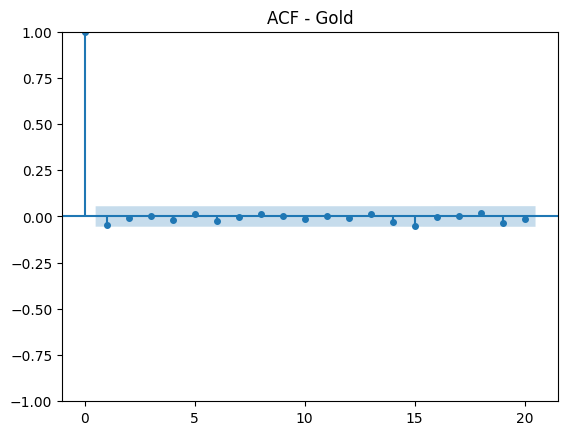

<Figure size 1000x500 with 0 Axes>

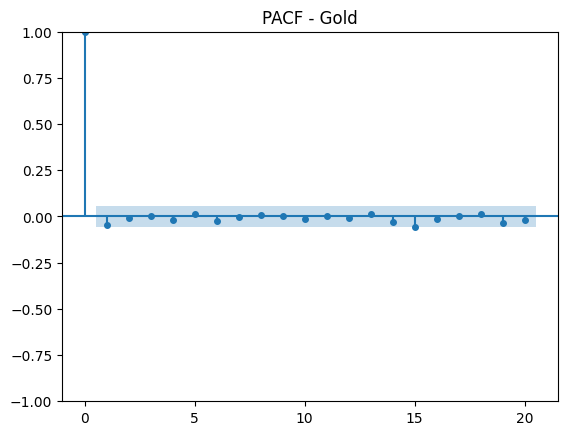

In [ ]:
plot_acf_pacf(gold_log['Close'], title_prefix='Gold')

In [ ]:
df_arima = testeaza_modele_arima(gold_log['Close'], p_max=3, d=0, q_max=3)
df_arima.head(20)

Model          AIC          BIC         HQIC       LogLik  \
1   ARIMA(0,0,1) -8023.289419 -8007.879969 -8017.498098  4014.644709   
4   ARIMA(1,0,0) -8023.246868 -8007.837418 -8017.455547  4014.623434   
0   ARIMA(0,0,0) -8022.276304 -8012.003337 -8018.415423  4013.138152   
8   ARIMA(2,0,0) -8021.347947 -8000.802014 -8013.626186  4014.673974   
5   ARIMA(1,0,1) -8021.347349 -8000.801416 -8013.625588  4014.673674   
2   ARIMA(0,0,2) -8021.325675 -8000.779742 -8013.603914  4014.662838   
6   ARIMA(1,0,2) -8019.742967 -7994.060551 -8010.090766  4014.871484   
9   ARIMA(2,0,1) -8019.387160 -7993.704743 -8009.734958  4014.693580   
12  ARIMA(3,0,0) -8019.352152 -7993.669736 -8009.699951  4014.676076   
3   ARIMA(0,0,3) -8019.319974 -7993.637558 -8009.667772  4014.659987   
7   ARIMA(1,0,3) -8017.470213 -7986.651314 -8005.887572  4014.735107   
13  ARIMA(3,0,1) -8017.349279 -7986.530380 -8005.766638  4014.674640   
10  ARIMA(2,0,2) -8017.346129 -7986.527229 -8005.763487  4014.673064   
11  ARIMA(2,0,3) -8015.577058 -7979.621676 -8002.063977  4014.788529   
14  ARIMA(3,0,2) -8015.351269 -7979.395886 -8001.838187  4014.675634   
15  ARIMA(3,0,3) -8014.539083 -7973.447218 -7999.095562  4015.269542   

    Num_Params    Sigma2  Skewness  Kurtosis  
1            3  0.000099 -0.527568  2.193266  
4            3  0.000099 -0.527686  2.192948  
0            2  0.000099 -0.538192  2.179923  
8            4  0.000099 -0.526043  2.194571  
5            4  0.000099 -0.526607  2.193381  
2            4  0.000099 -0.526244  2.194260  
6            5  0.000099 -0.524490  2.193646  
9            5  0.000099 -0.525714  2.194300  
12           5  0.000099 -0.525891  2.195167  
3            5  0.000099 -0.525680  2.196608  
7            6  0.000099 -0.525399  2.193425  
13           6  0.000099 -0.525911  2.195269  
10           6  0.000099 -0.526139  2.194237  
11           7  0.000099 -0.525312  2.192862  
14           7  0.000099 -0.525855  2.194779  
15           8  0.000098 -0.520890  2.155673

In [ ]:
best_model_gold_arima = ARIMA(gold_log['Close'], order=(1, 0, 1))
best_fitted_gold = best_model_gold_arima.fit()
print(best_fitted_gold.summary())

r_gold = best_fitted_gold.resid
rsq_gold = r_gold**2
rsq_gold.head()

                               SARIMAX Results                                
Dep. Variable:                   GC=F   No. Observations:                 1257
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4014.674
Date:                Mon, 19 May 2025   AIC                          -8021.347
Time:                        14:58:46   BIC                          -8000.801
Sample:                             0   HQIC                         -8013.626
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.760      0.078   -5.49e-05       0.001
ar.L1          0.1275      0.470      0.271      0.786      -0.794       1.049
ma.L1         -0.1751      0.465     -0.377      0.7

Date
2020-05-20    0.000010
2020-05-21    0.000313
2020-05-22    0.000047
2020-05-26    0.000309
2020-05-27    0.000004
dtype: float64

# **Markov-Switching GARCH**

Here I tried volatility clustering before fitting GARCH models. MSGARCH package available in R should be used for best predictions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from arch import arch_model
import warnings
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

def compute_msgarch_from_residuals(residuals, alpha=0.01):
    """
    MSGARCH Model: Markov Switching + GARCH on pre-calculated residuals.

    Parameters:
    - residuals: pd.Series or np.ndarray containing residual values
    - alpha: significance level for VaR estimation (default: 0.01)

    Returns:
    - Dictionary containing GARCH models by regime, regime probabilities,
      assigned regimes, volatility by regime, and mixture volatility.
    """

    if isinstance(residuals, np.ndarray):
        residuals = pd.Series(residuals)

    # Markov Switching model
    markov_model = MarkovRegression(residuals, k_regimes=3, trend='c', switching_variance=True)
    markov_result = markov_model.fit()
    regimes_probs = markov_result.smoothed_marginal_probabilities
    assigned_regimes = regimes_probs.idxmax(axis=1)

    garch_models = {}
    cond_vols_all = pd.DataFrame(index=residuals.index)

    # Fit GARCH model for each regime
    for k in range(3):
        subset = residuals[assigned_regimes == k]
        if len(subset) < 50:
            continue

        model = arch_model(subset * 100, vol='GARCH', p=1, q=1)
        result = model.fit(disp='off')
        garch_models[f'Regime_{k}'] = result

        model_full = arch_model(residuals * 100, vol='GARCH', p=1, q=1)
        result_full = model_full.fit(starting_values=result.params, disp='off')
        forecast = result_full.forecast(start=0, reindex=True)
        vol = np.sqrt(forecast.variance.iloc[:, 0]) / 100
        cond_vols_all[f'Regime_{k}'] = vol

    # Mixture volatility
    vol_total = pd.Series(0, index=residuals.index)
    for k in range(3):
        vol_total += regimes_probs[k] * cond_vols_all[f'Regime_{k}']

    # Colors for plots
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

    # Plot mixture volatility
    plt.figure(figsize=(12, 5))
    plt.plot(vol_total.index, vol_total, label='Estimated Volatility (MSGARCH)', color='black')
    plt.title('Estimated Conditional Volatility (MSGARCH)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot regime probabilities
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    regime_labels = ['Low', 'Medium', 'High']

    for k in range(3):
        axs[k].plot(regimes_probs.index, regimes_probs[k],
                    label=f'Regime {k} ({regime_labels[k]})',
                    color=colors[k])
        axs[k].set_title(f'Probability of Belonging - {regime_labels[k]} Volatility Regime')
        axs[k].legend()
        axs[k].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'GARCH_models': garch_models,
        'Regime_Probabilities': regimes_probs,
        'Assigned_Regimes': assigned_regimes,
        'Volatility_by_Regime': cond_vols_all,
        'Volatility_Mixture': vol_total
    }

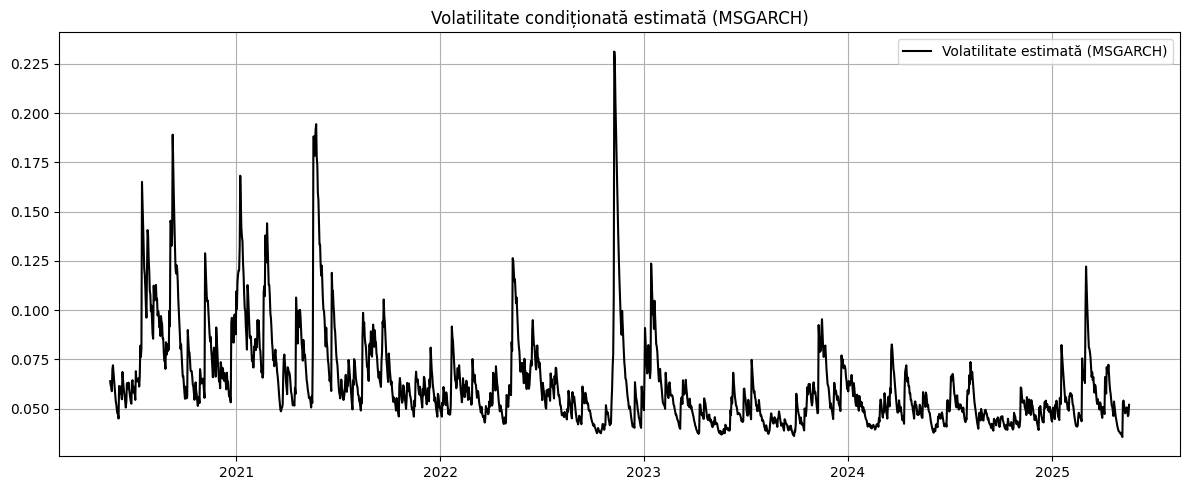

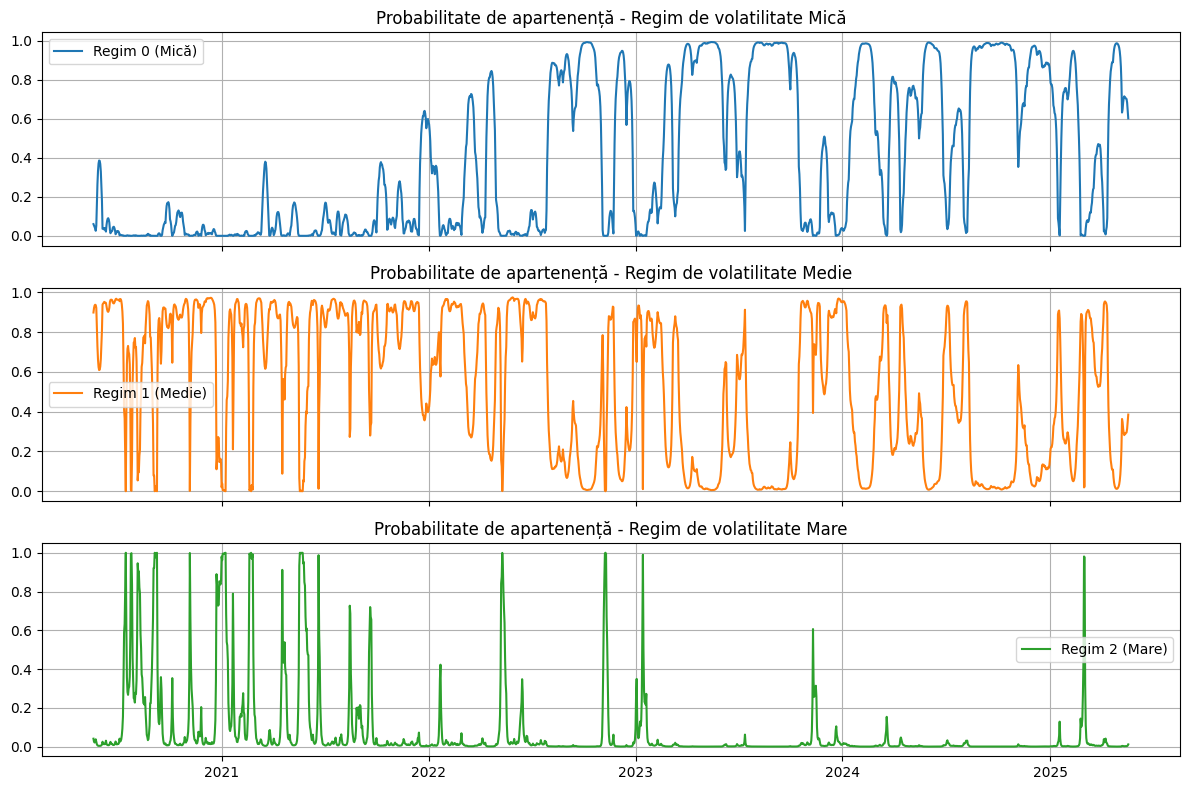

{'GARCH_models': {'Regim_0':                      Constant Mean - GARCH Model Results                      
  Dep. Variable:                   None   R-squared:                       0.000
  Mean Model:             Constant Mean   Adj. R-squared:                  0.000
  Vol Model:                      GARCH   Log-Likelihood:               -1978.77
  Distribution:                  Normal   AIC:                           3965.54
  Method:            Maximum Likelihood   BIC:                           3983.98
                                          No. Observations:                  743
  Date:                Mon, May 19 2025   Df Residuals:                      742
  Time:                        16:34:39   Df Model:                            1
                                   Mean Model                                
                   coef    std err          t      P>|t|     95.0% Conf. Int.
  ---------------------------------------------------------------------------
  mu      

In [ ]:
compute_msgarch_from_residuals(r_solana)

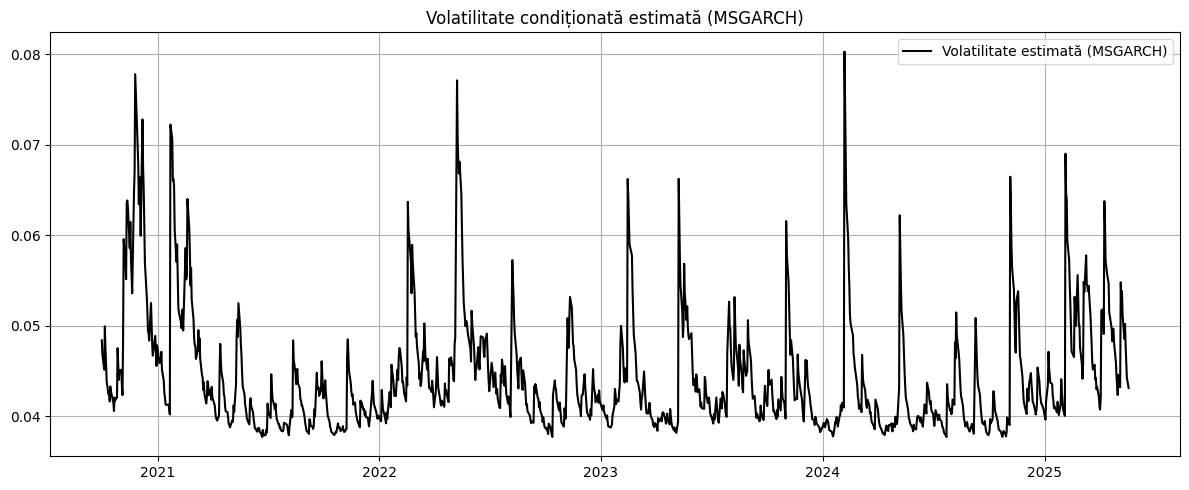

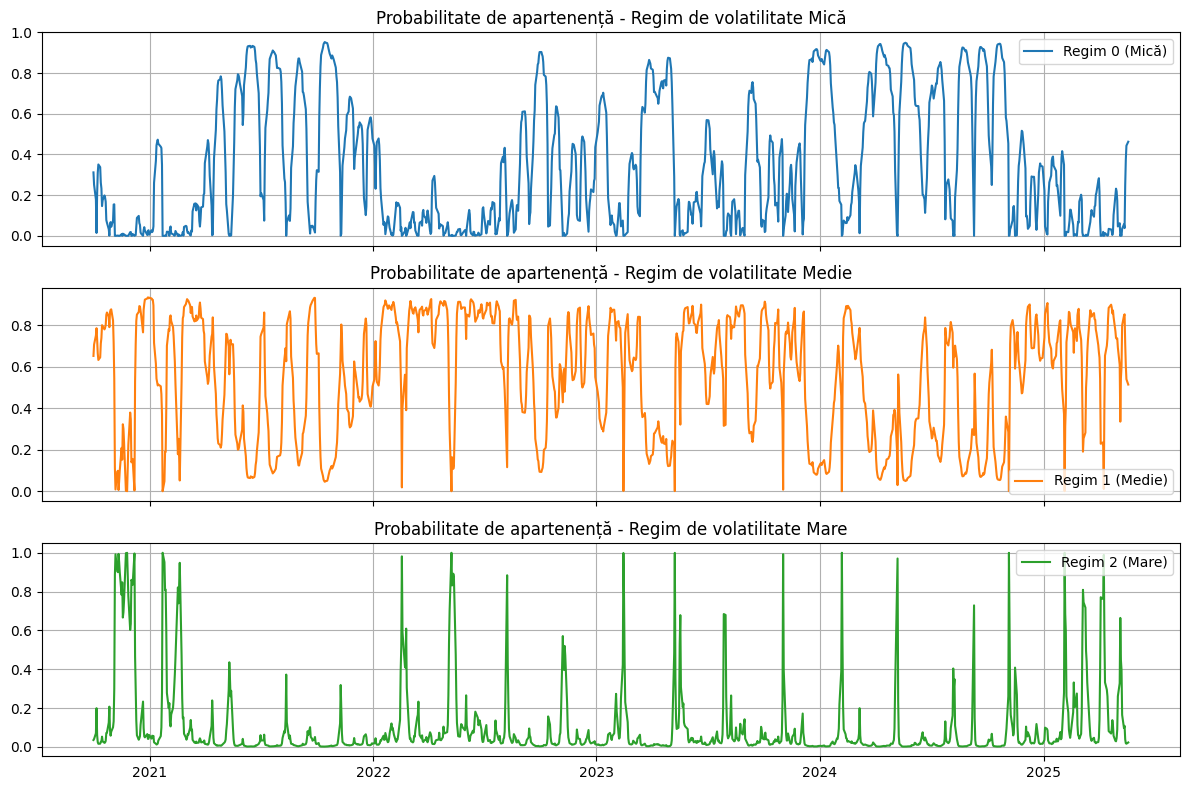

{'GARCH_models': {'Regim_0':                      Constant Mean - GARCH Model Results                      
  Dep. Variable:                   None   R-squared:                       0.000
  Mean Model:             Constant Mean   Adj. R-squared:                  0.000
  Vol Model:                      GARCH   Log-Likelihood:               -807.862
  Distribution:                  Normal   AIC:                           1623.72
  Method:            Maximum Likelihood   BIC:                           1639.44
                                          No. Observations:                  376
  Date:                Mon, May 19 2025   Df Residuals:                      375
  Time:                        16:36:21   Df Model:                            1
                                 Mean Model                               
                   coef    std err          t      P>|t|  95.0% Conf. Int.
  ------------------------------------------------------------------------
  mu            -0.

In [ ]:
compute_msgarch_from_residuals(r_palantir)

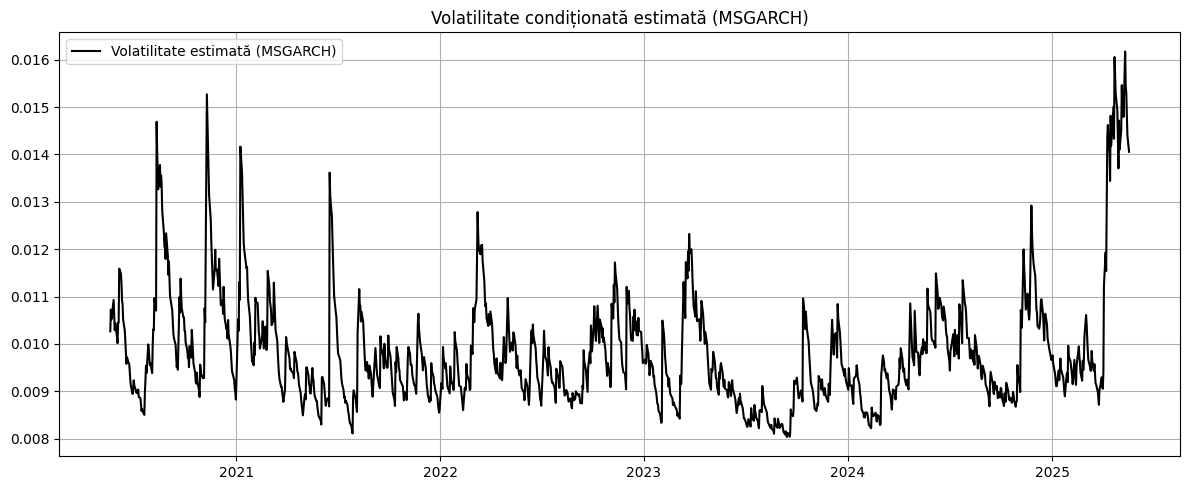

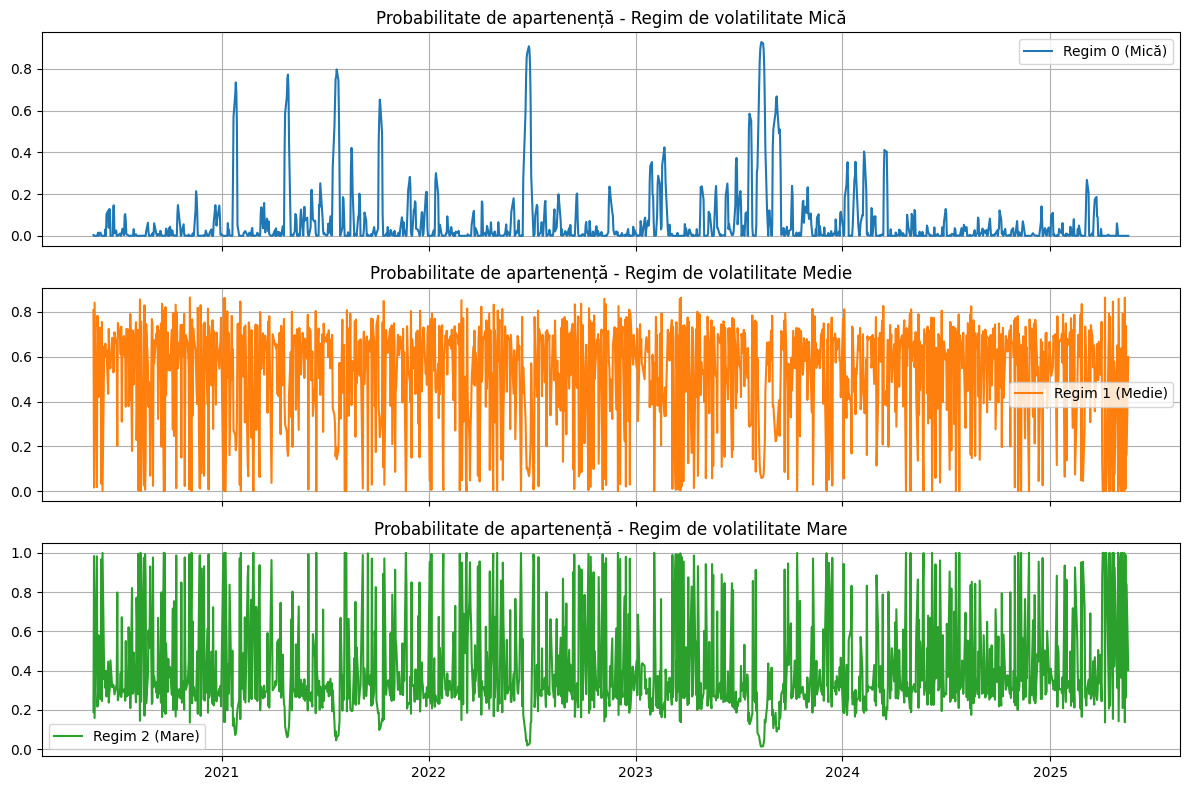

{'GARCH_models': {'Regim_0':                      Constant Mean - GARCH Model Results                      
  Dep. Variable:                   None   R-squared:                       0.000
  Mean Model:             Constant Mean   Adj. R-squared:                  0.000
  Vol Model:                      GARCH   Log-Likelihood:                7.99623
  Distribution:                  Normal   AIC:                          -7.99245
  Method:            Maximum Likelihood   BIC:                          0.179752
                                          No. Observations:                   57
  Date:                Mon, May 19 2025   Df Residuals:                       56
  Time:                        16:36:36   Df Model:                            1
                                 Mean Model                               
                   coef    std err          t      P>|t|  95.0% Conf. Int.
  ------------------------------------------------------------------------
  mu            -0.

In [ ]:
compute_msgarch_from_residuals(r_gold)

# **HURST Exponent**



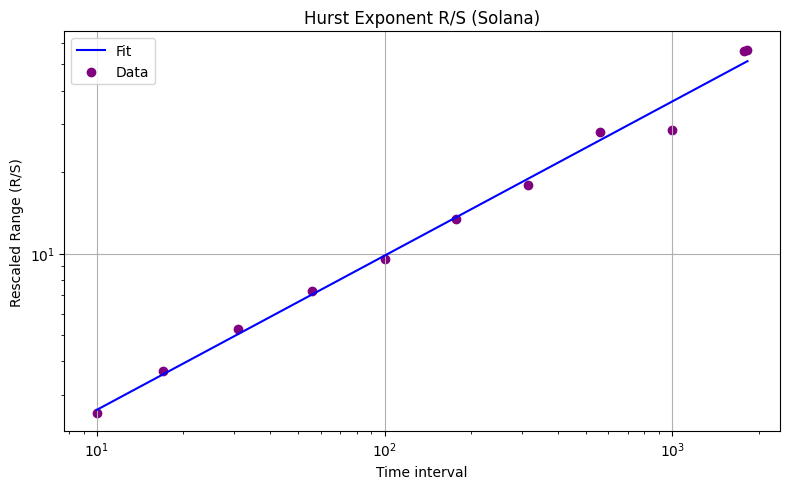

Hurst MFDFA (Solana): 0.606


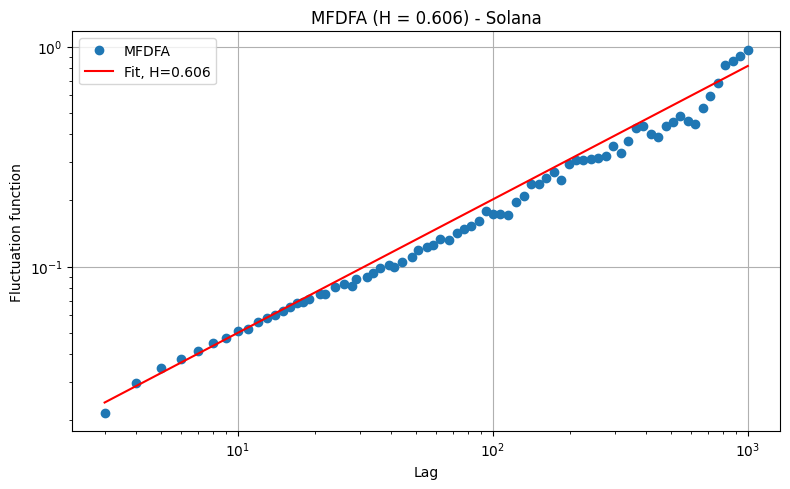

{'Hurst_RS': np.float64(0.5697694585854819),
 'Hurst_corrected': np.float64(0.5504918364213781),
 'Hurst_MFDFA': array([0.60637889])}

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hurst import compute_Hc
import nolds
from MFDFA import MFDFA
import warnings
warnings.filterwarnings("ignore")

def test_fractal_market_hypothesis(series, title=''):
    """
    Applies tests to verify the Fractal Market Hypothesis on a price or log-return series.

    Parameters:
    - series: pandas Series (e.g., log-prices or log-returns)
    - title: descriptive title for plots

    Returns:
    - Dictionary with Hurst (R/S), Corrected Hurst, and H from MFDFA
    """

    # Ensure no NaNs before passing to compute_Hc
    series_cleaned = series.dropna()

    # 1. Estimate Hurst via R/S (Rescaled Range) method
    H, c, data = compute_Hc(series_cleaned, kind='price', simplified=False)

    # Plot R/S
    plt.figure(figsize=(8, 5))
    plt.plot(data[0], c * data[0]**H, label="Fit", color="blue")
    plt.scatter(data[0], data[1], label="Data", color="purple")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Time interval")
    plt.ylabel("Rescaled Range (R/S)")
    plt.title(f"Hurst Exponent R/S ({title})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Corrected Hurst (nolds)
    H_corrected = nolds.hurst_rs(series_cleaned, nvals=None, fit='RANSAC', debug_plot=False,
                 debug_data=False, plot_file=True, corrected=True, unbiased=True)

    # 3. MFDFA
    lag = np.unique(np.logspace(0.1, 3, 100).astype(int))
    q = 2
    dfa_lags, dfa_vals = MFDFA(series_cleaned.values, lag=lag, q=q, order=1)

    plt.figure(figsize=(8, 5))
    plt.loglog(dfa_lags, dfa_vals, 'o', label='MFDFA')
    fit_slice = min(15, len(dfa_lags))
    if fit_slice > 1:
        slope = np.polyfit(np.log(dfa_lags[:fit_slice]), np.log(dfa_vals[:fit_slice]), 1)[0]
        H_mfdfa = slope
        plt.plot(dfa_lags, np.exp(np.polyval(np.polyfit(np.log(dfa_lags[:fit_slice]), np.log(dfa_vals[:fit_slice]), 1), np.log(dfa_lags))),
                label=f'Fit, H={float(H_mfdfa):.3f}', color='red')
        print(f"Hurst MFDFA ({title}): {float(H_mfdfa):.3f}")  # Display value for clarity
    else:
        H_mfdfa = np.nan
        print(f"Not enough data points to calculate Hurst MFDFA for {title}")

    plt.xlabel("Lag")
    plt.ylabel("Fluctuation function")
    plt.title(f"MFDFA (H = {'NaN' if np.isnan(H_mfdfa) else float(H_mfdfa):.3f}) - {title}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'Hurst_RS': H,
        'Hurst_corrected': H_corrected,
        'Hurst_MFDFA': H_mfdfa
    }

test_fractal_market_hypothesis(solana_log['Close'], title='Solana')

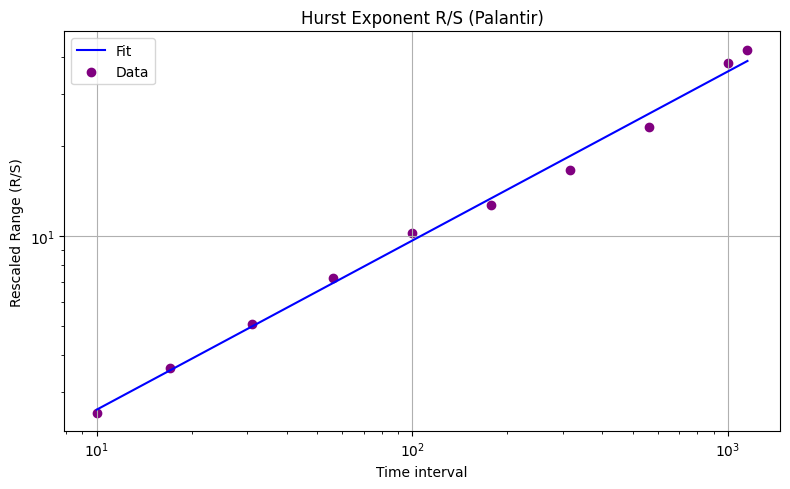

Hurst MFDFA (Palantir): 0.670


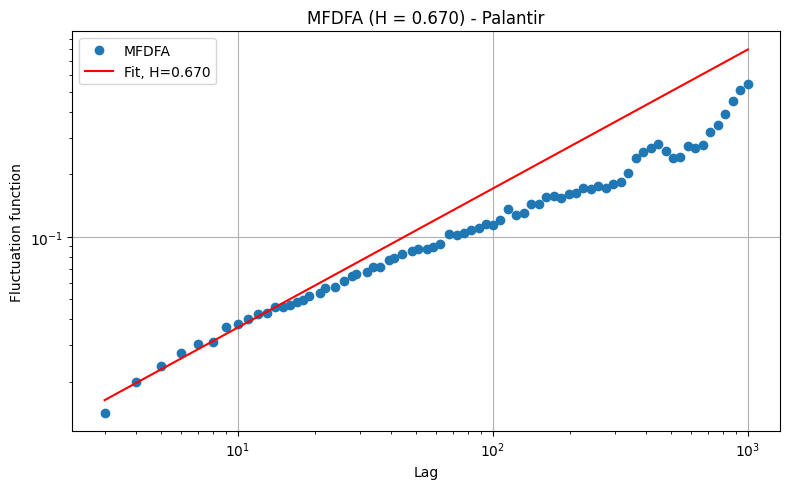

{'Hurst_RS': np.float64(0.567674783903728),
 'Hurst_corrected': np.float64(0.537615919135079),
 'Hurst_MFDFA': array([0.6702121])}

In [ ]:
test_fractal_market_hypothesis(palantir_log['Close'], title='Palantir')

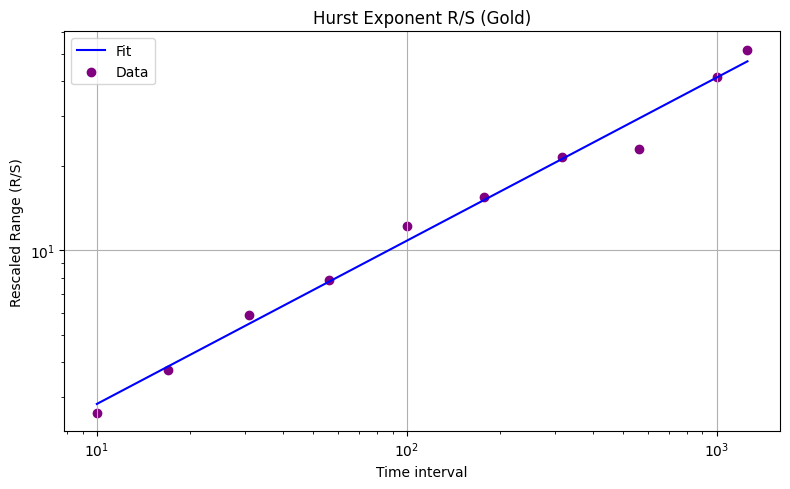

Hurst MFDFA (Gold): 0.505


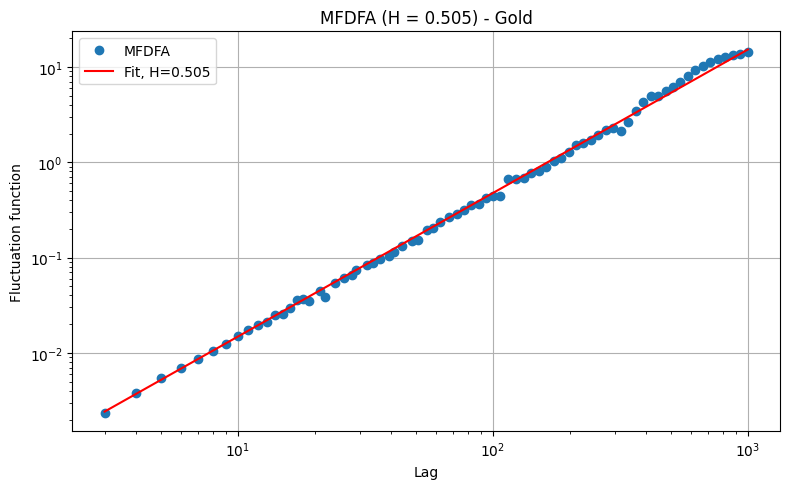

{'Hurst_RS': np.float64(0.5805918905148475),
 'Hurst_corrected': np.float64(0.9066506664420577),
 'Hurst_MFDFA': array([0.50538502])}

In [ ]:
test_fractal_market_hypothesis(gold_log['Close'], title='Gold')